In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import scipy 
import anndata
import scvi.dataset as scvd
import sys
from sklearn.utils import shuffle
import iqplot

import NCA_analysis as nc
data_path = "data" 

/home/joeyta/anaconda3/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
/home/joeyta/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
smartseq = pd.read_csv((data_path + "/smartseq.csv"))

In [4]:
smartseq = smartseq.transpose()[1:]

In [5]:
SM_metadata = pd.read_csv(data_path + "/SMART-seq_VMH_metadata.csv")

In [6]:
SM_metadata = SM_metadata.dropna()

In [7]:
SM_metadata["sample_name"].values

array(['SM-GE4R2_S062_E1-50', 'SM-GE4SI_S356_E1-50',
       'SM-GE4SI_S172_E1-50', ..., 'SM-D9D7G_S25_E1-50',
       'SM-D9D7M_S89_E1-50', 'SM-D9E6R_S81_E1-50'], dtype=object)

In [8]:
smartseq = smartseq.loc[SM_metadata["sample_name"].values]

In [9]:
# read in SMARTseq data
SM_adata = anndata.AnnData(smartseq)

/home/joeyta/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
# Add relevant metadata to anndata object
SM_adata.obs["sample_name"] = SM_metadata["sample_name"].values
SM_adata.obs["cca_cluster_id"] = SM_metadata["cca_cluster_id"].values
SM_adata.obs["cca_cluster"] = SM_metadata["cca_cluster_label"].values
SM_adata.obs["sex_label"] = SM_metadata["sex_label"].values
SM_adata.obs["cca_cluster_color"] = SM_metadata["cca_cluster_color"].values

In [11]:
# seed for reproducability
np.random.seed(seed = 15)

In [12]:
metadata = pd.read_csv(data_path +'/10x_metadata_VMH_neuron.csv')

In [13]:
cells_metadata = pd.read_csv(data_path +'/10x_metadata_cell.csv')
cells_metadata.dropna(inplace = True)

In [101]:
def create_dataset(folder):
    """This function takes in a folder that is the name of the 10X data sample and performs the entire process for creating and formatting 
    the anndata object, and then returns an AnnDataset"""
    path = data_path + "/10x_VMH_" + folder + "/"
    matrix = anndata.read_mtx(path + 'matrix.mtx')
    origin = '10x_VMH_' + folder
    batch = cells_metadata.loc[cells_metadata['orig.ident'] == origin , ['sample_name']].values[0][0].split('_')[0]
    print(batch)
    t2g = pd.read_csv(path + 'genes.tsv', header = None, names = ['gene_id', 'gene_name'], sep = '\t')
    barcodes = pd.read_csv(path + 'barcodes.tsv', header = None, names = ['barcode'])
    print(len(barcodes))
    barcodes['barcode'] = barcodes['barcode'].str.strip('-1')
    barcodes['barcode'] = str(batch) + '_' + barcodes['barcode']
    barcodes['cluster_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cluster_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cca_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_color'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['sex_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['sex_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['sex_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cluster_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['neuron_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_id']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_id']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_color']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_color']].values
    barcodes.loc[barcodes["cca_label"] == "Esr1_2", "cca_label"] = "Esr1_2|3"
    barcodes.loc[barcodes["cca_label"] == "Esr1_3", "cca_label"] = "Esr1_2|3"
    genes = t2g.gene_name.values
    matrix = matrix.T
    matrix.var["gene_name"] = genes
    matrix.var.index = matrix.var["gene_name"]
    matrix.obs["cell_barcode"] = barcodes.barcode.values
    matrix.obs["sex_label"] = barcodes.sex_label.values
    matrix.obs["cca_cluster"] = barcodes.cca_label.values
    matrix.obs['cca_cluster_id'] = barcodes.cca_id.values
    matrix.obs['cca_cluster_color'] = barcodes.cca_color.values
    matrix.obs['sample_name'] = [folder] * len(barcodes.barcode)
    values = np.nan_to_num((matrix.obs.cca_cluster_id).astype(np.float))
    labeled_cells = np.where(values != 0)[0]
    print(len(labeled_cells))
    val = matrix.n_obs - 1 
    #random_cells = np.random.randint(low = 0, high = val, size = 1500)
    matrix = matrix[labeled_cells, :]
    if (len(labeled_cells) == 1):
        return 
    return scvd.AnnDatasetFromAnnData(matrix)
#     return matrix
    #return labeled_cells

In [102]:
folders = ["Female_Control_1", "Female_Mating_not_receptive_1", "Female_Mating_not_receptive_2", 
           "Female_Mating_not_receptive_3", "Female_Plain_1", "Male_Aggression_1", "Male_Aggression_2", 
           "Male_Aggression_3", 
           "Male_Control_1", "Male_Control_2", "Male_Control_3", "Male_M-F_CI_dangled_1", "Male_M-M_CI_dangled_2",
           "Male_M-F_CI_pencil_cup_1","Male_M-M_CI_dangled_1", "Male_M-M_CI_pencil_cup_1", "Male_Mating_1",
           "Male_Others_1", "Male_Others_2", "Male_Others_3", "Male_Others_4", "Male_Plain_1", "Male_Plain_2", 
           "Male_Social_Fear_Singly-housed_1", "Male_Social_Fear_Singly-housed_2", "Male_Social_Fear_Group-housed_1"]

In [103]:
print(np.unique(cells_metadata['orig.ident']))

['10x_VMH_Female_Control_1' '10x_VMH_Female_Mating_not_receptive_1'
 '10x_VMH_Female_Mating_not_receptive_2'
 '10x_VMH_Female_Mating_not_receptive_3' '10x_VMH_Female_Plain_1'
 '10x_VMH_Male_Aggression_1' '10x_VMH_Male_Aggression_2'
 '10x_VMH_Male_Aggression_3' '10x_VMH_Male_Control_1'
 '10x_VMH_Male_Control_2' '10x_VMH_Male_Control_3'
 '10x_VMH_Male_M-F_CI_dangled_1' '10x_VMH_Male_M-F_CI_pencil_cup_1'
 '10x_VMH_Male_M-M_CI_dangled_1' '10x_VMH_Male_M-M_CI_dangled_2'
 '10x_VMH_Male_M-M_CI_pencil_cup_1' '10x_VMH_Male_Mating_1'
 '10x_VMH_Male_Others_1' '10x_VMH_Male_Others_2' '10x_VMH_Male_Others_3'
 '10x_VMH_Male_Others_4' '10x_VMH_Male_Plain_1' '10x_VMH_Male_Plain_2'
 '10x_VMH_Male_Social_Fear_Group-housed_1'
 '10x_VMH_Male_Social_Fear_Singly-housed_1'
 '10x_VMH_Male_Social_Fear_Singly-housed_2']


In [104]:
l = []

In [105]:
len(folders)

26

In [106]:
# create dataset for each separate sample and concatenates them
for f in folders:
    print(f)
    l.append(create_dataset(f))

Female_Control_1
4
10030
3194
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 3194 to 3194 cells                                                 
Female_Mating_not_receptive_1
15
9454
1405
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                        

1855
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 1855 to 1855 cells                                                 
Male_M-M_CI_dangled_2
26
4919
1472
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing t

WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 1732 to 1732 cells                                                 
Male_Social_Fear_Singly-housed_1
17
8478
1825
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downs

In [107]:
# removes any datasets that did not have any entries
l = list(filter(None, l))

In [108]:
gene_dataset = scvd.GeneExpressionDataset()

In [109]:
# combine all datasets into 1
gene_dataset.populate_from_datasets(l)

INFO     Merging datasets. Input objects are modified in place.                              
INFO     Gene names and cell measurement names are assumed to have a non-null intersection   
         between datasets.                                                                   
INFO     Keeping 27998 genes                                                                 
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data        

INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data        

In [110]:
adata = gene_dataset.to_anndata()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [111]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 40
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 2

mito_criteria = 5

n_top_genes = 2000

n_bins = 20

flavor="seurat"

In [112]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

Pre-processing of data following filtering outlined in Kim et al., 2019

In [113]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

In [114]:
SM_adata.obs["cell_counts"] = SM_adata.X.sum(axis=1)
SM_adata.var["gene_counts"] = nd(SM_adata.X.sum(axis=0))

SM_adata.obs["n_genes"] = nd((SM_adata.X>0).sum(axis=1))
SM_adata.var["n_cells"] = nd((SM_adata.X>0).sum(axis=0))

SM_mito_genes = SM_adata.var_names.str.startswith('mt-')
SM_adata.obs["percent_mito"] = SM_adata[:,SM_mito_genes].X.sum(axis=1)/SM_adata.X.sum(axis=1)*100

In [115]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [116]:
SM_adata.obs["pass_count_filter"] = SM_adata.obs["cell_counts"] > cell_threshold
SM_adata.obs["pass_mito_filter"] = SM_adata.obs.percent_mito < mito_criteria
SM_adata.var["pass_gene_filter"] = SM_adata.var["n_cells"] > gene_threshold

In [117]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [118]:
SM_cell_mask = np.logical_and(SM_adata.obs["pass_count_filter"].values, SM_adata.obs["pass_mito_filter"].values)
SM_gene_mask = SM_adata.var["pass_gene_filter"].values

In [119]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 41,580 cells x 27,998 genes
    New shape: 23,261 cells x 21,375 genes


In [120]:
print("Current Shape: {:,} cells x {:,} genes".format(SM_adata.shape[0], SM_adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(SM_cell_mask.sum(), SM_gene_mask.sum()))

Current Shape: 1,078 cells x 30,862 genes
    New shape: 1,078 cells x 23,568 genes


In [121]:
SM_data = SM_adata[SM_cell_mask, SM_gene_mask]

In [122]:
SM_data.layers["raw"] = SM_data.X
scale_num = 1000000
SM_data.layers["norm"] = normalize(SM_data.X, norm="l1", axis=1)*scale_num
SM_data.layers["log1p"] = np.log1p(SM_data.layers["norm"])
SM_data.uns = OrderedDict([("log1p", {"base":None})])
SM_data.X = SM_data.layers["log1p"]

In [123]:
data = adata[cell_mask, gene_mask]

In [124]:
data.layers["raw"] = data.X

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [125]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [126]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [127]:
data.X = data.layers["log1p"]

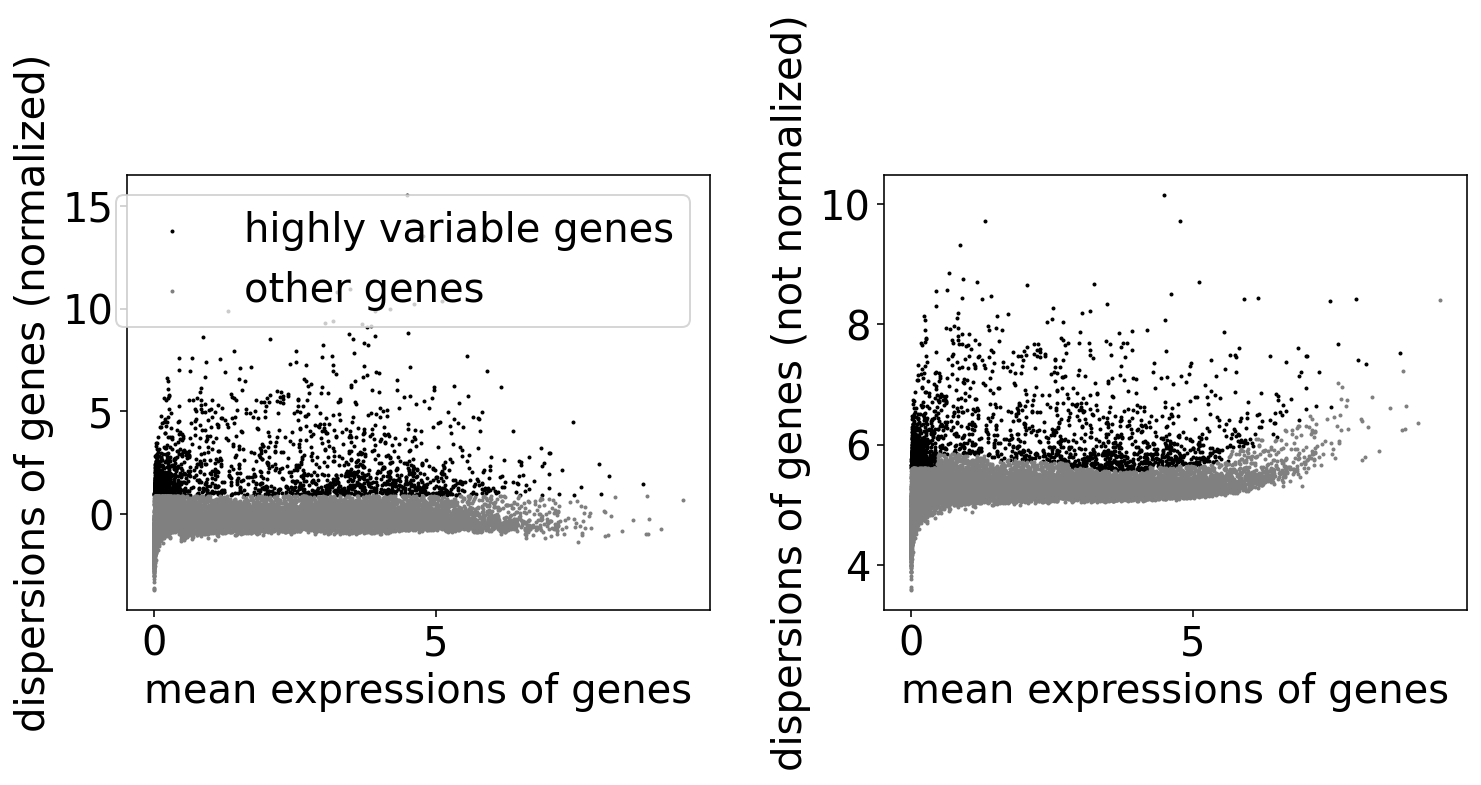

In [128]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values
sc.pl.highly_variable_genes(data)

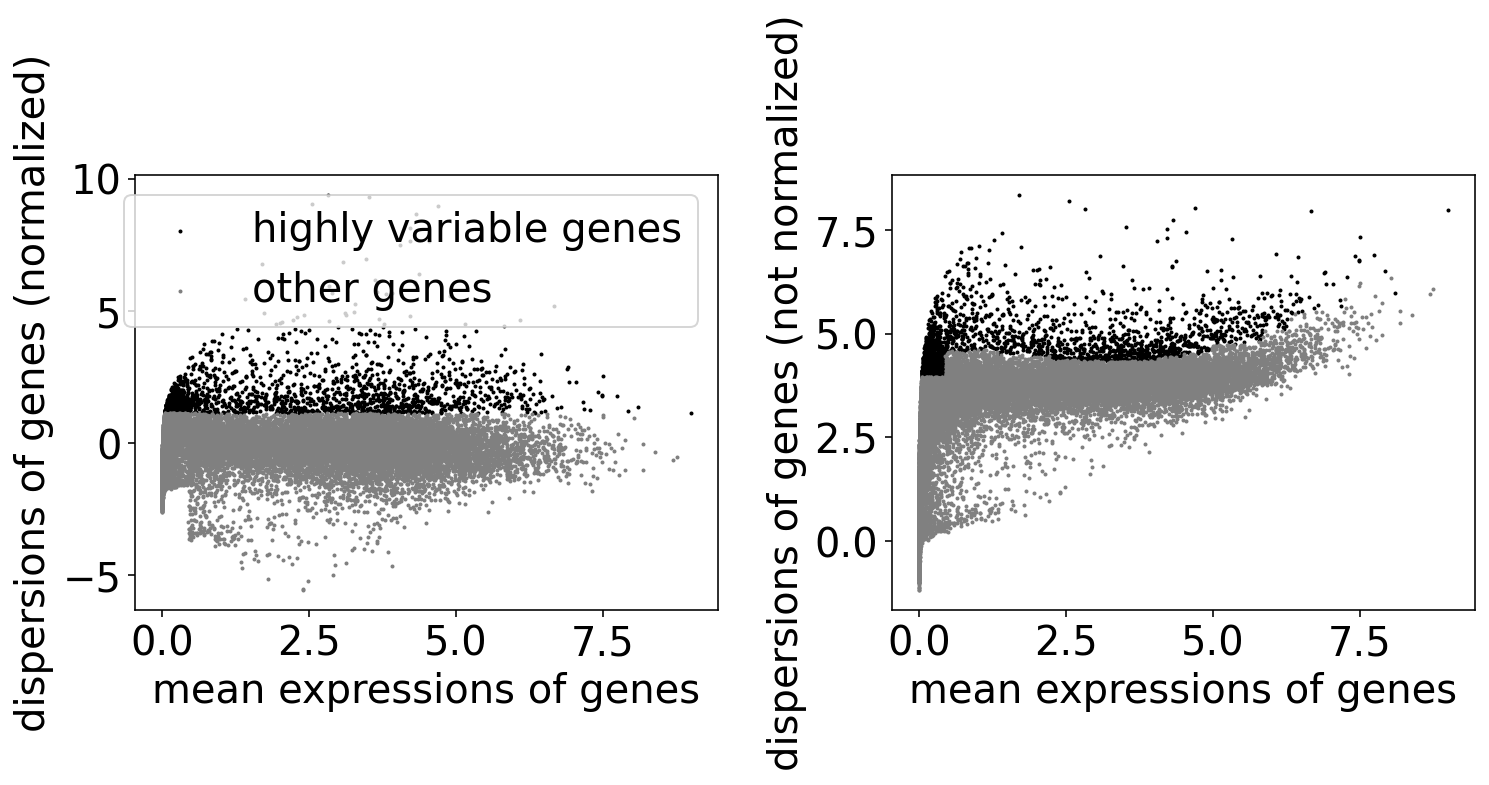

In [129]:
sc.pp.highly_variable_genes(SM_data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
SM_hvg_mask = SM_data.var.highly_variable.values
sc.pl.highly_variable_genes(SM_data)

In [130]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"]
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 20 s, sys: 7.69 s, total: 27.7 s
Wall time: 27.7 s


In [131]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = SM_data.layers["log1p"]
SM_data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
SM_data.X = SM_data.layers["scale"]

del mat

CPU times: user 1.01 s, sys: 329 ms, total: 1.34 s
Wall time: 1.33 s


In [132]:
hvg_data = data[:, hvg_mask]
SM_hvg_data = SM_data[:, SM_hvg_mask]
combined = hvg_data.concatenate(SM_hvg_data, join = "outer")

In [ ]:
np.save("SM_gene_names.npy", SM_hvg_mask)

In [133]:
scipy.io.mmwrite("tenx_hvg_raw.mtx", hvg_data.layers["raw"])
hvg_data.write_csvs("tenx_hvg")

writing .csv files to tenx_hvg


In [ ]:
allGenes = pd.DataFrame()
allGenes['gene_name'] = list(hvg_data.var_names)
allGenes.to_csv('var.csv')

In [134]:
scipy.io.mmwrite("smartseq_hvg_raw.mtx", SM_hvg_data.layers["raw"])
SM_hvg_data.write_csvs("SM_hvg")

writing .csv files to SM_hvg


In [46]:
combined.X = np.nan_to_num(combined.X)

Save combined anndata objects (count matrices) across conditions

In [47]:
combined.write('comboVMH.h5ad')

... storing 'cca_cluster' as categorical
... storing 'sample_name' as categorical
... storing 'sex_label' as categorical
... storing 'cell_types' as categorical
... storing 'cell_barcode' as categorical
... storing 'cca_cluster_color' as categorical
... storing 'gene_name-0' as categorical
... storing 'pass_gene_filter-0' as categorical
... storing 'highly_variable-0' as categorical
... storing 'pass_gene_filter-1' as categorical
... storing 'highly_variable-1' as categorical


#### **Read in previously saved data (h5ad)**

In [5]:
combined = anndata.read('comboVMH.h5ad')
combined

AnnData object with n_obs × n_vars = 9065 × 3998
    obs: 'cca_cluster', 'cca_cluster_id', 'sample_name', 'sex_label', 'cell_types', 'cell_barcode', 'cca_cluster_color', 'batch_indices', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'batch'
    var: 'gene_name-0', 'gene_counts-0', 'n_cells-0', 'pass_gene_filter-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_counts-1', 'n_cells-1', 'pass_gene_filter-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    layers: 'log1p', 'norm', 'raw', 'scale'

In [6]:
#nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", ndims = 10, PCA_dims = 50, out_label = "NCA_cca_only")

PCA Only vs NCA Unique Nearest Neighbors Analysis

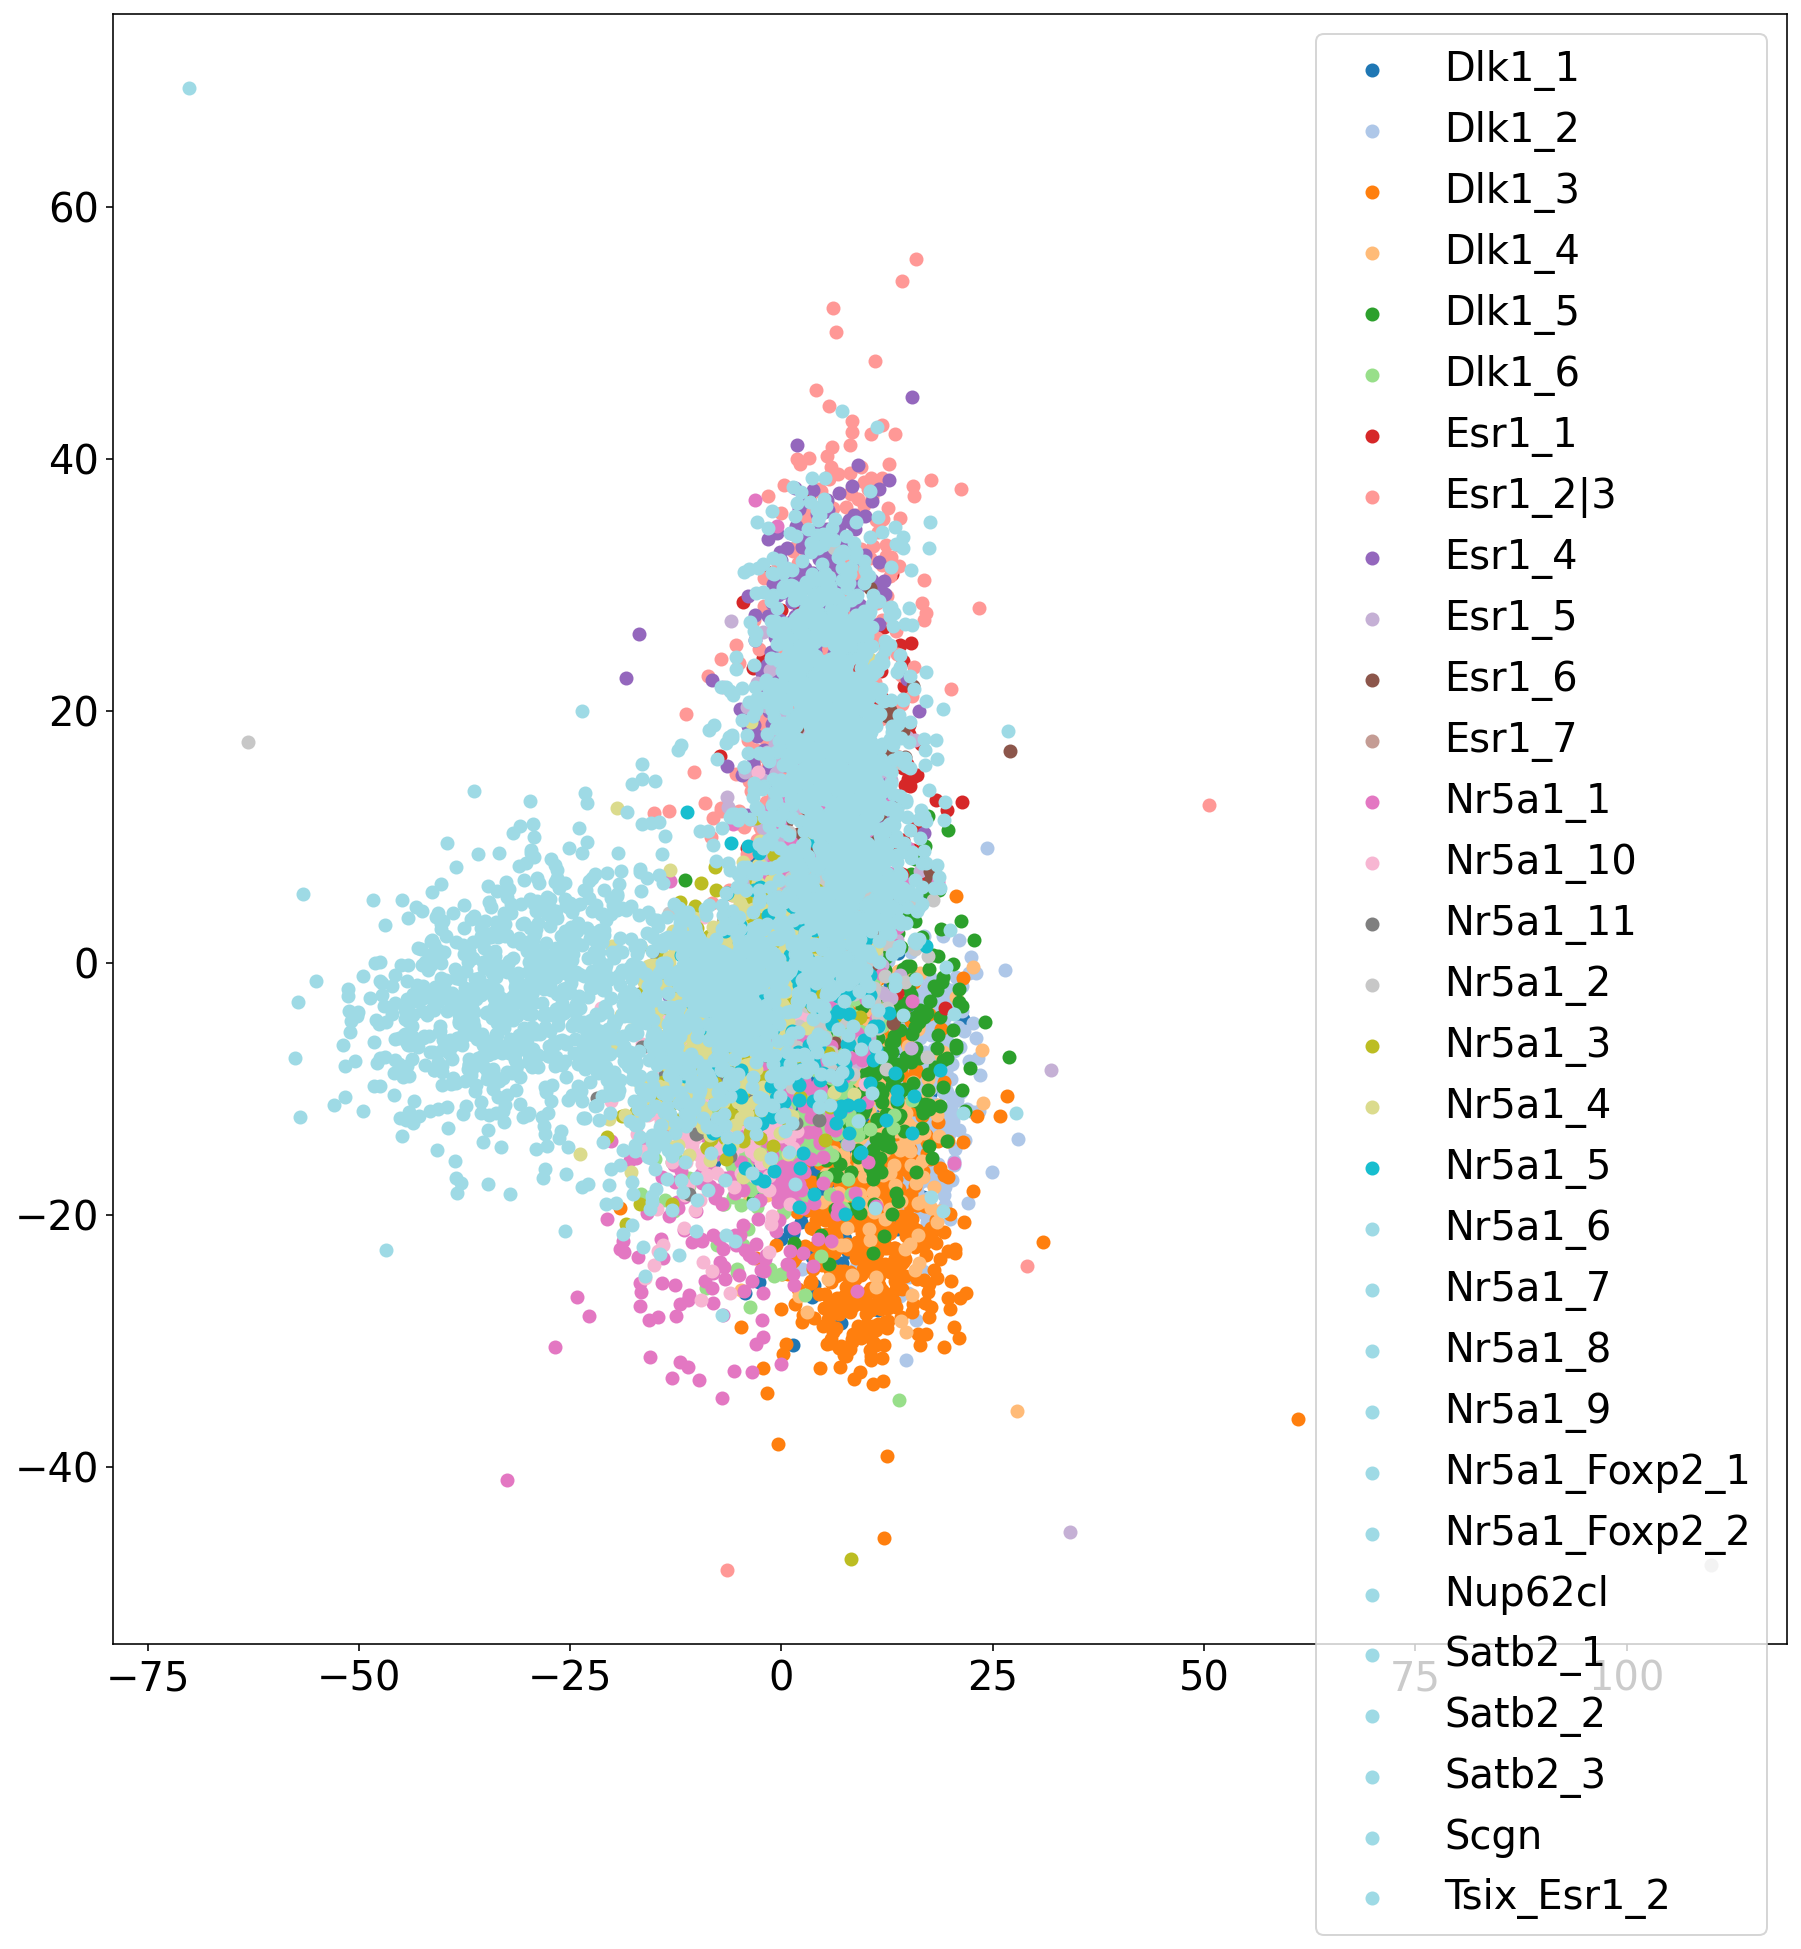

In [7]:
from sklearn.neighbors import NearestNeighbors

nc.PCA_analysis(combined, ndims = 10)

nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "knnComp_PCA_NCA_50_10", PCA_dims = 50, ndims = 10, PCA_init = True)

In [9]:
pca_frac, pca_neigh = nc.frac_unique_neighbors(combined, 'cca_cluster', nca_label = 'X_PCA_10', metric = 1,neighbors = 30)
nca_frac, nca_neigh = nc.frac_unique_neighbors(combined, 'cca_cluster', nca_label = 'knnComp_PCA_NCA_50_10', metric = 1,neighbors = 30)

In [17]:
nca_neigh['Dlk1_6']

array(['Dlk1_1', 'Dlk1_2', 'Dlk1_3', 'Dlk1_4', 'Dlk1_5', 'Dlk1_6',
       'Esr1_1', 'Esr1_2|3', 'Esr1_5', 'Esr1_6', 'Nr5a1_1', 'Nr5a1_10',
       'Nr5a1_11', 'Nr5a1_2', 'Nr5a1_3', 'Nr5a1_4', 'Nr5a1_5', 'Nr5a1_6',
       'Nr5a1_7', 'Nr5a1_8', 'Nr5a1_9', 'Nr5a1_Foxp2_1', 'Nr5a1_Foxp2_2',
       'Nup62cl', 'Satb2_1', 'Satb2_2', 'Scgn', 'Tsix_Esr1_2'],
      dtype=object)

Text(0.5, 1.0, 'Fraction of Unique Nearest Neighbors (NNs) in PCA space versus PCA-NCA')

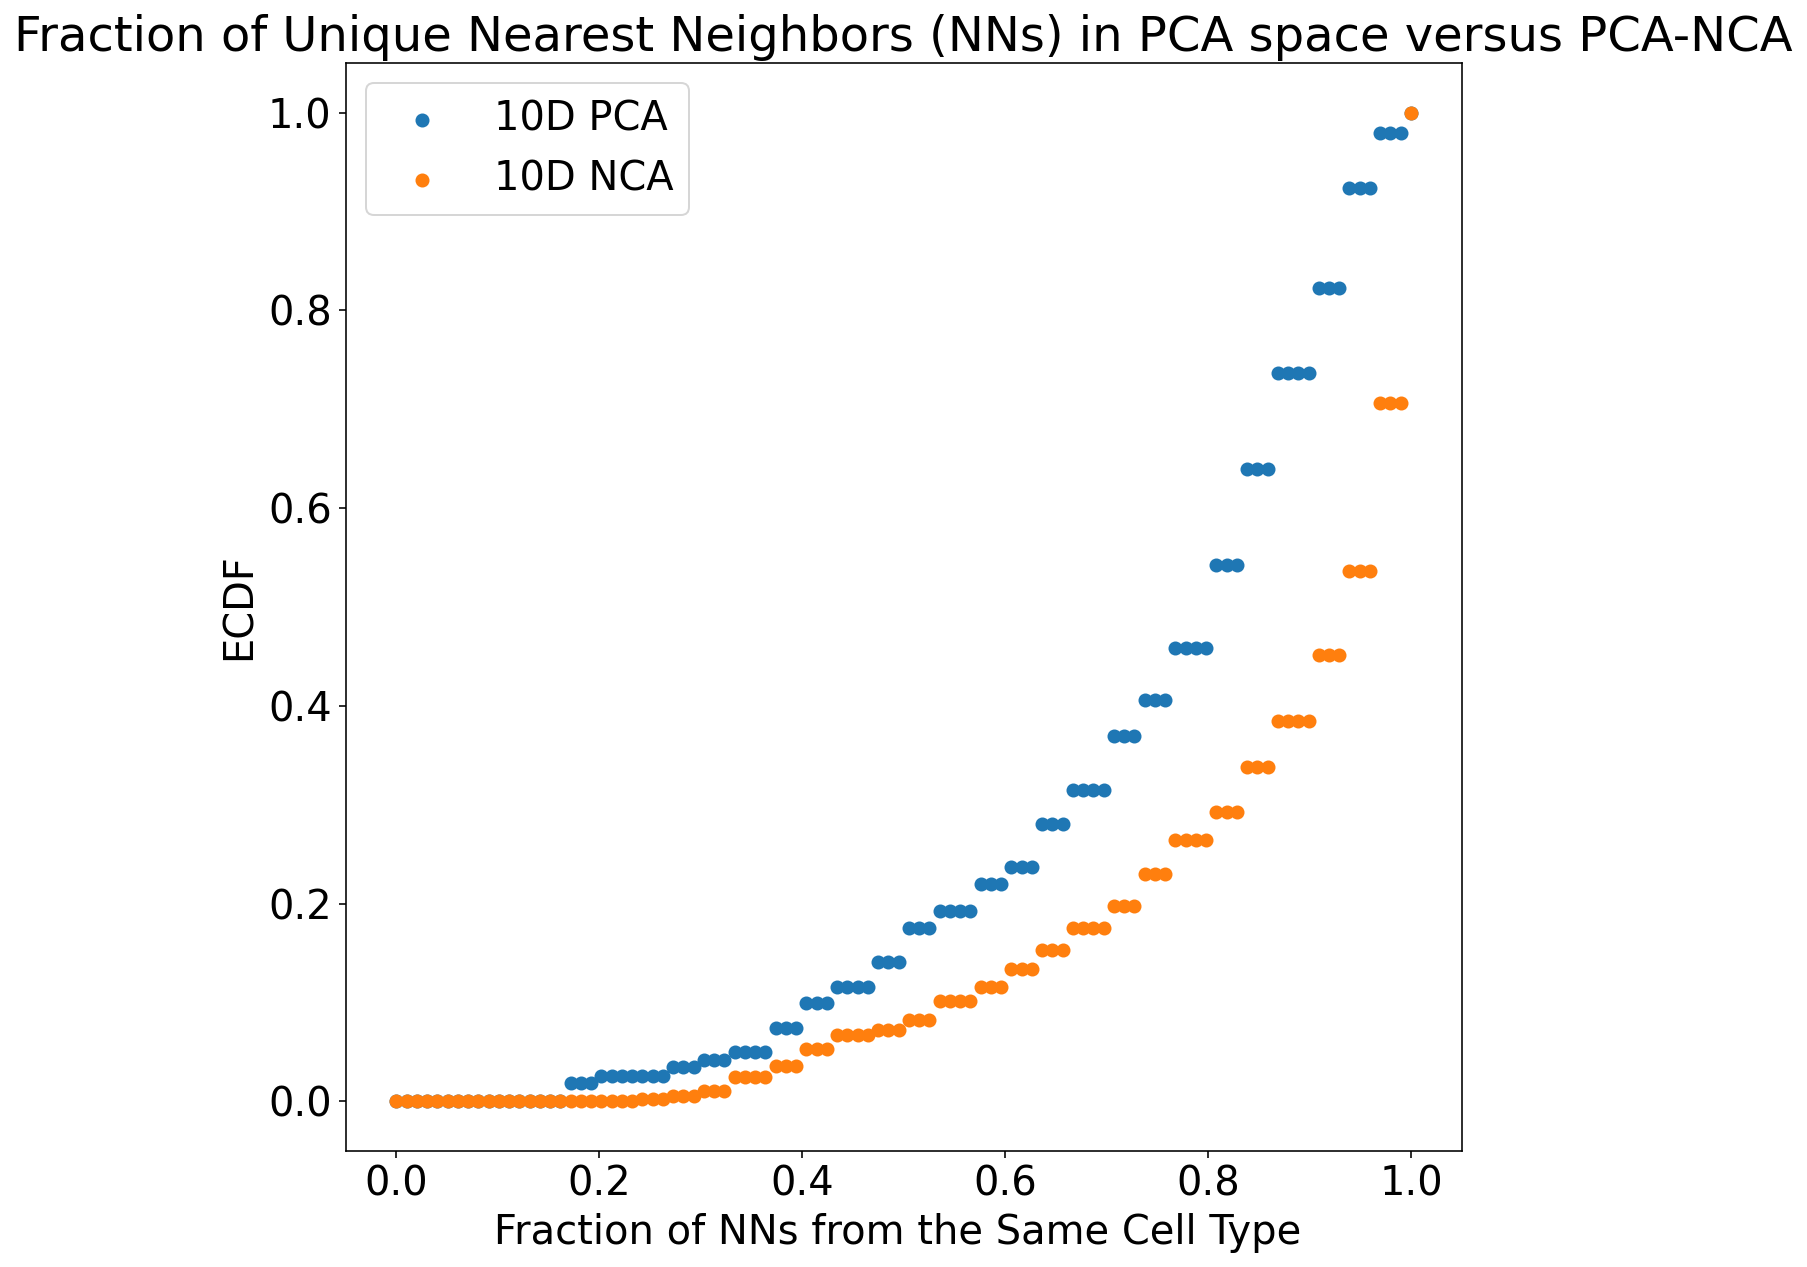

In [51]:
x = np.linspace(0.0, 1.0, num = 100)

knn_dists = [pca_frac,nca_frac]
labs = ['10D PCA','10D NCA']

fig, ax = plt.subplots(figsize = (10, 10))
for i, data in enumerate(knn_dists):
    y = nc.ecdf(x, list(data.values())[0])
    ax.scatter(x, y, label = labs[i])
ax.legend()
ax.set_xlabel("Fraction of NNs from the Same Cell Type ")
ax.set_ylabel("ECDF")
plt.title("Fraction of Unique Nearest Neighbors (NNs) in PCA space versus PCA-NCA")

Centroid Distances Analysis and Overfitting Checks

In [52]:
nc.PCA_analysis(combined, ndims = 10)

In [53]:
nc.PCA_analysis(combined, ndims = 20)
nc.PCA_analysis(combined, ndims = 30)
nc.PCA_analysis(combined, ndims = 40)
nc.PCA_analysis(combined, ndims = 50)
nc.PCA_analysis(combined, ndims = 60)
nc.PCA_analysis(combined, ndims = 70)

In [54]:
PCA_dists_10D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_10")
PCA_dists_20D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_20")
PCA_dists_30D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_30")
PCA_dists_40D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_40")
PCA_dists_50D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_50")
PCA_dists_60D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_60")
PCA_dists_70D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="X_PCA_70")

In [55]:
PCA_dists = [PCA_dists_10D, PCA_dists_20D, PCA_dists_30D, PCA_dists_40D, PCA_dists_50D, PCA_dists_60D, PCA_dists_70D]

In [59]:
pca_frac['Dlk1_1']

[0.8333333333333334,
 0.7333333333333333,
 0.8,
 0.8666666666666667,
 0.6666666666666666,
 0.6,
 0.7666666666666667,
 0.8333333333333334,
 0.7,
 0.5666666666666667,
 0.6333333333333333,
 0.7666666666666667,
 0.36666666666666664,
 0.7,
 0.8333333333333334,
 0.5666666666666667,
 0.43333333333333335,
 0.6666666666666666,
 0.6666666666666666,
 0.5,
 0.4666666666666667,
 0.5,
 0.7,
 0.8333333333333334,
 0.7333333333333333,
 0.8,
 0.43333333333333335,
 0.7333333333333333,
 0.5666666666666667,
 0.3,
 0.7,
 0.6666666666666666,
 0.7333333333333333,
 0.16666666666666666,
 0.4,
 0.7666666666666667,
 0.7333333333333333,
 0.6666666666666666,
 0.6666666666666666,
 0.9,
 0.4666666666666667,
 0.36666666666666664,
 0.7666666666666667,
 0.4666666666666667,
 0.8666666666666667,
 0.7333333333333333,
 0.9,
 0.8333333333333334,
 0.8,
 0.9,
 0.6666666666666666,
 0.36666666666666664,
 0.3333333333333333,
 0.6666666666666666,
 0.4,
 0.43333333333333335,
 0.3,
 0.5666666666666667,
 0.7,
 0.8333333333333334,
 0.

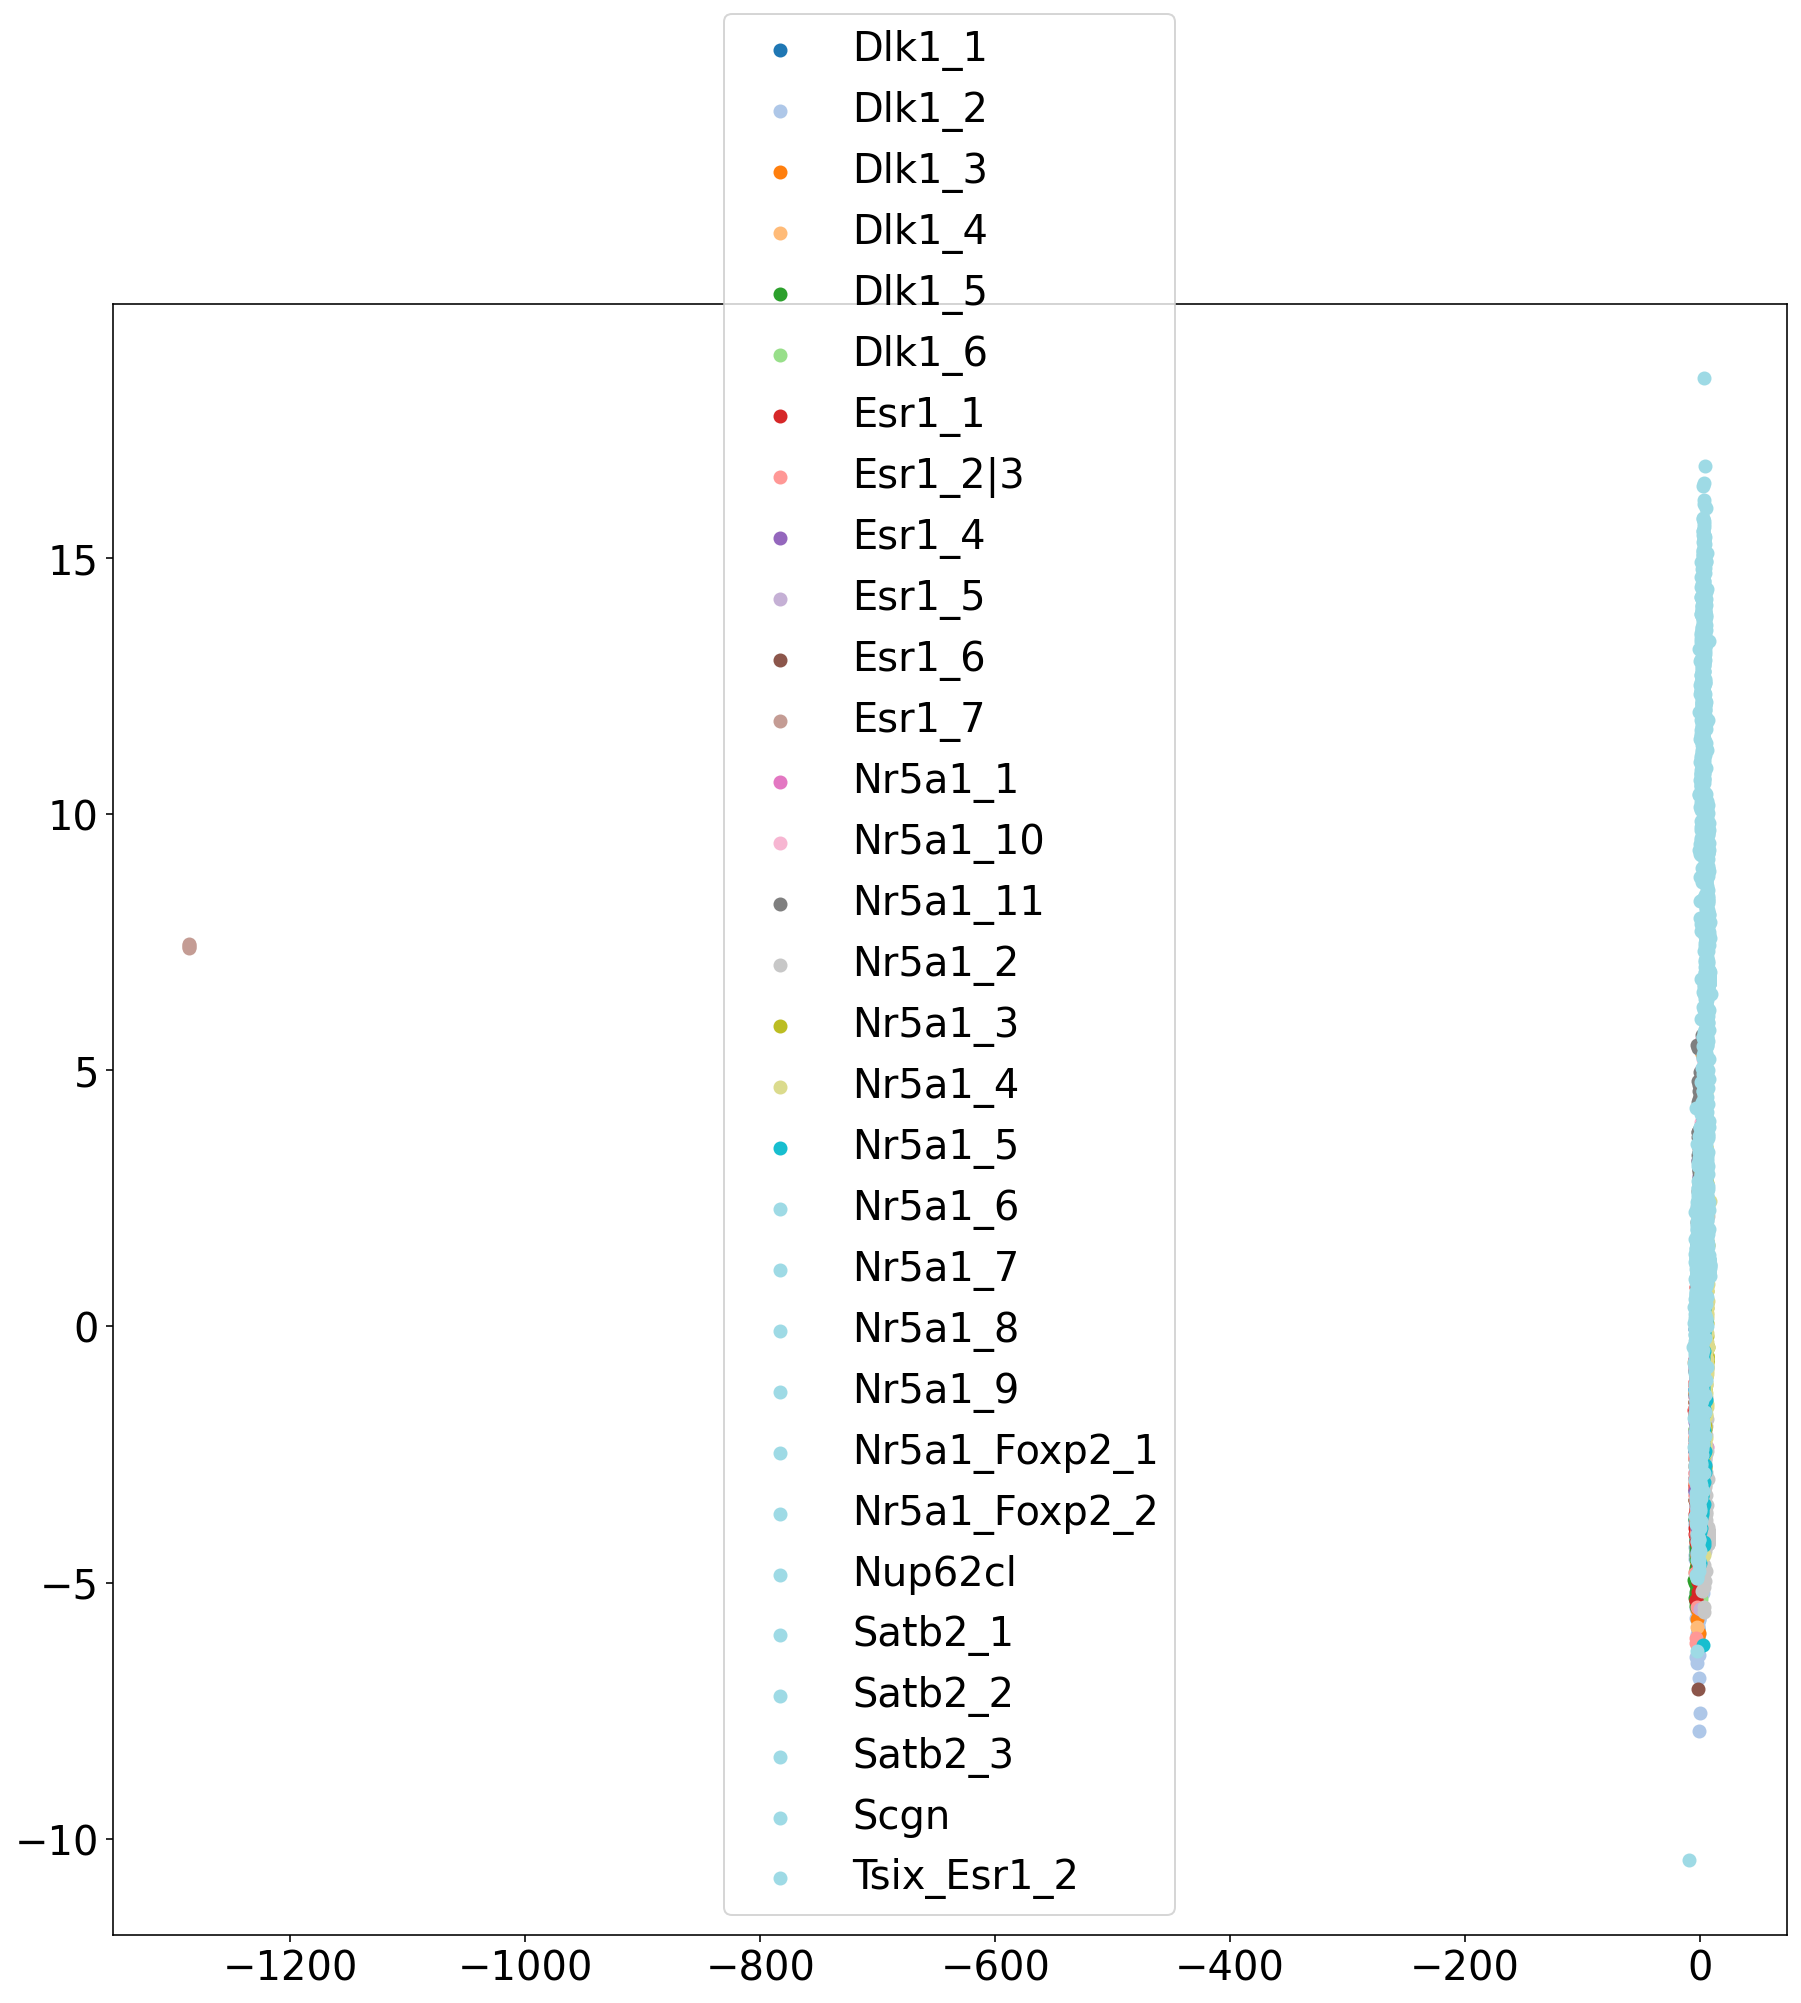

In [52]:
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_no_PCA", PCA_dims = 50, ndims = 10, PCA_init = False)
NCA_10D_dists = nc.distance_from_centroid(combined, "cca_cluster",  nca_label="NCA_no_PCA")

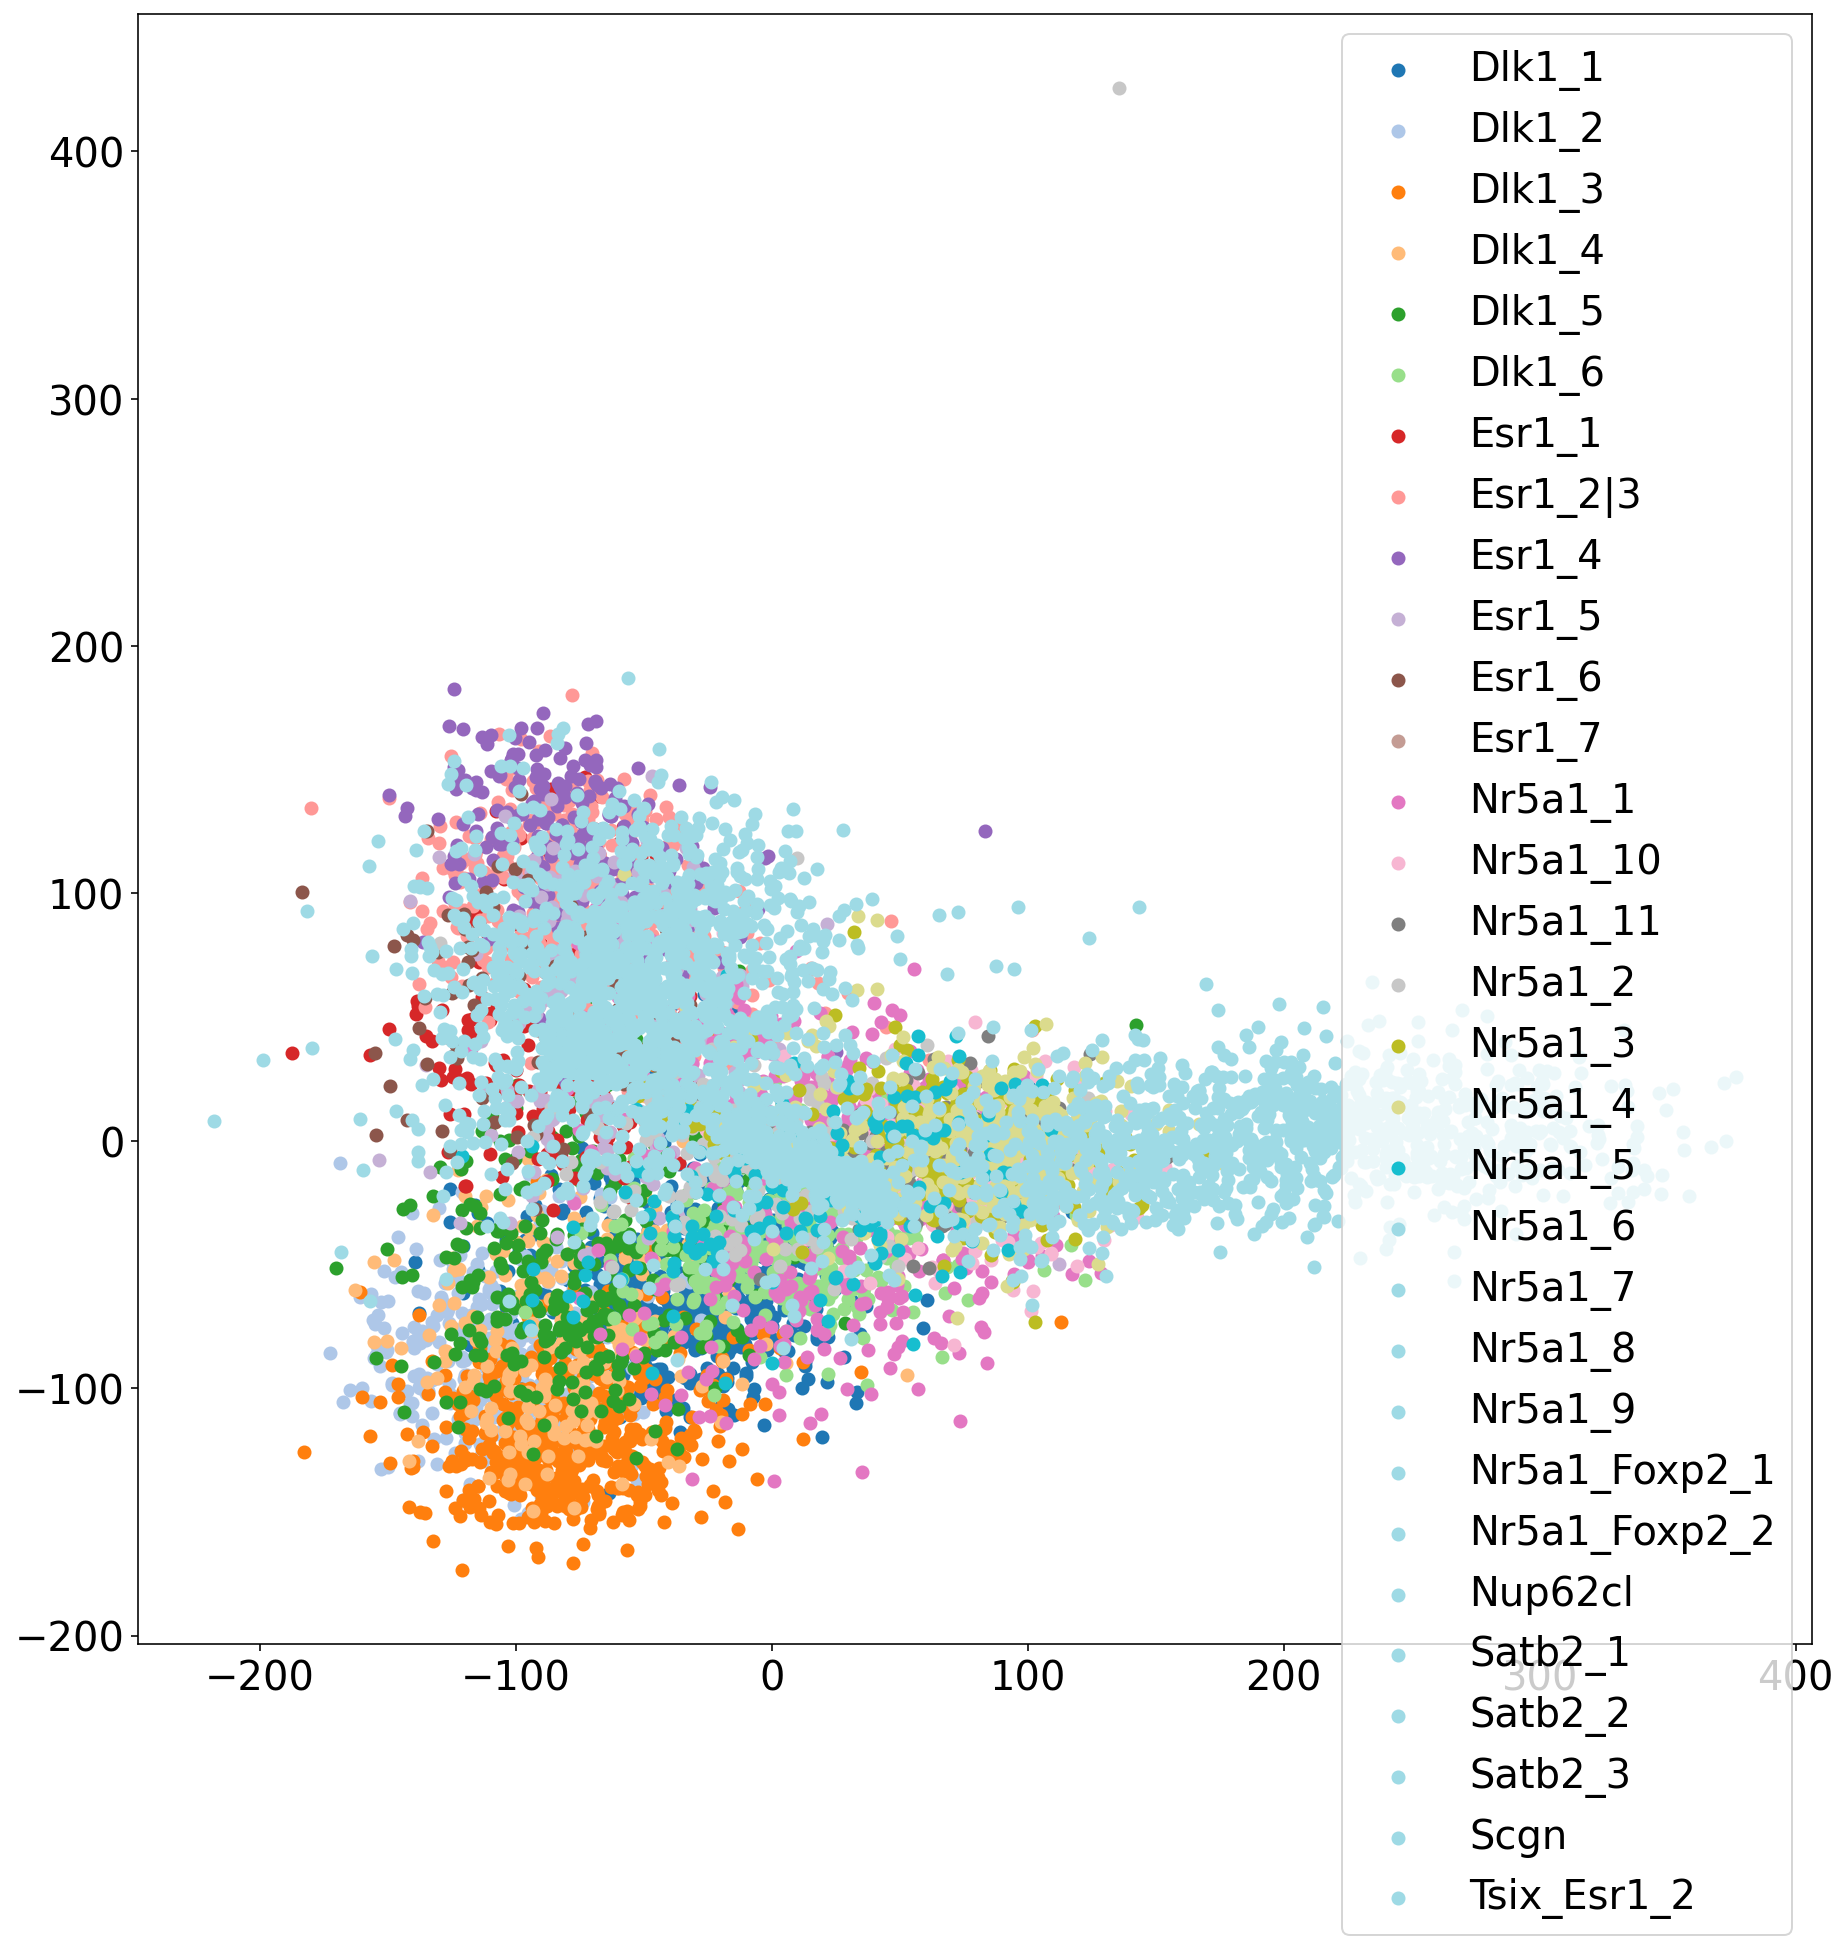

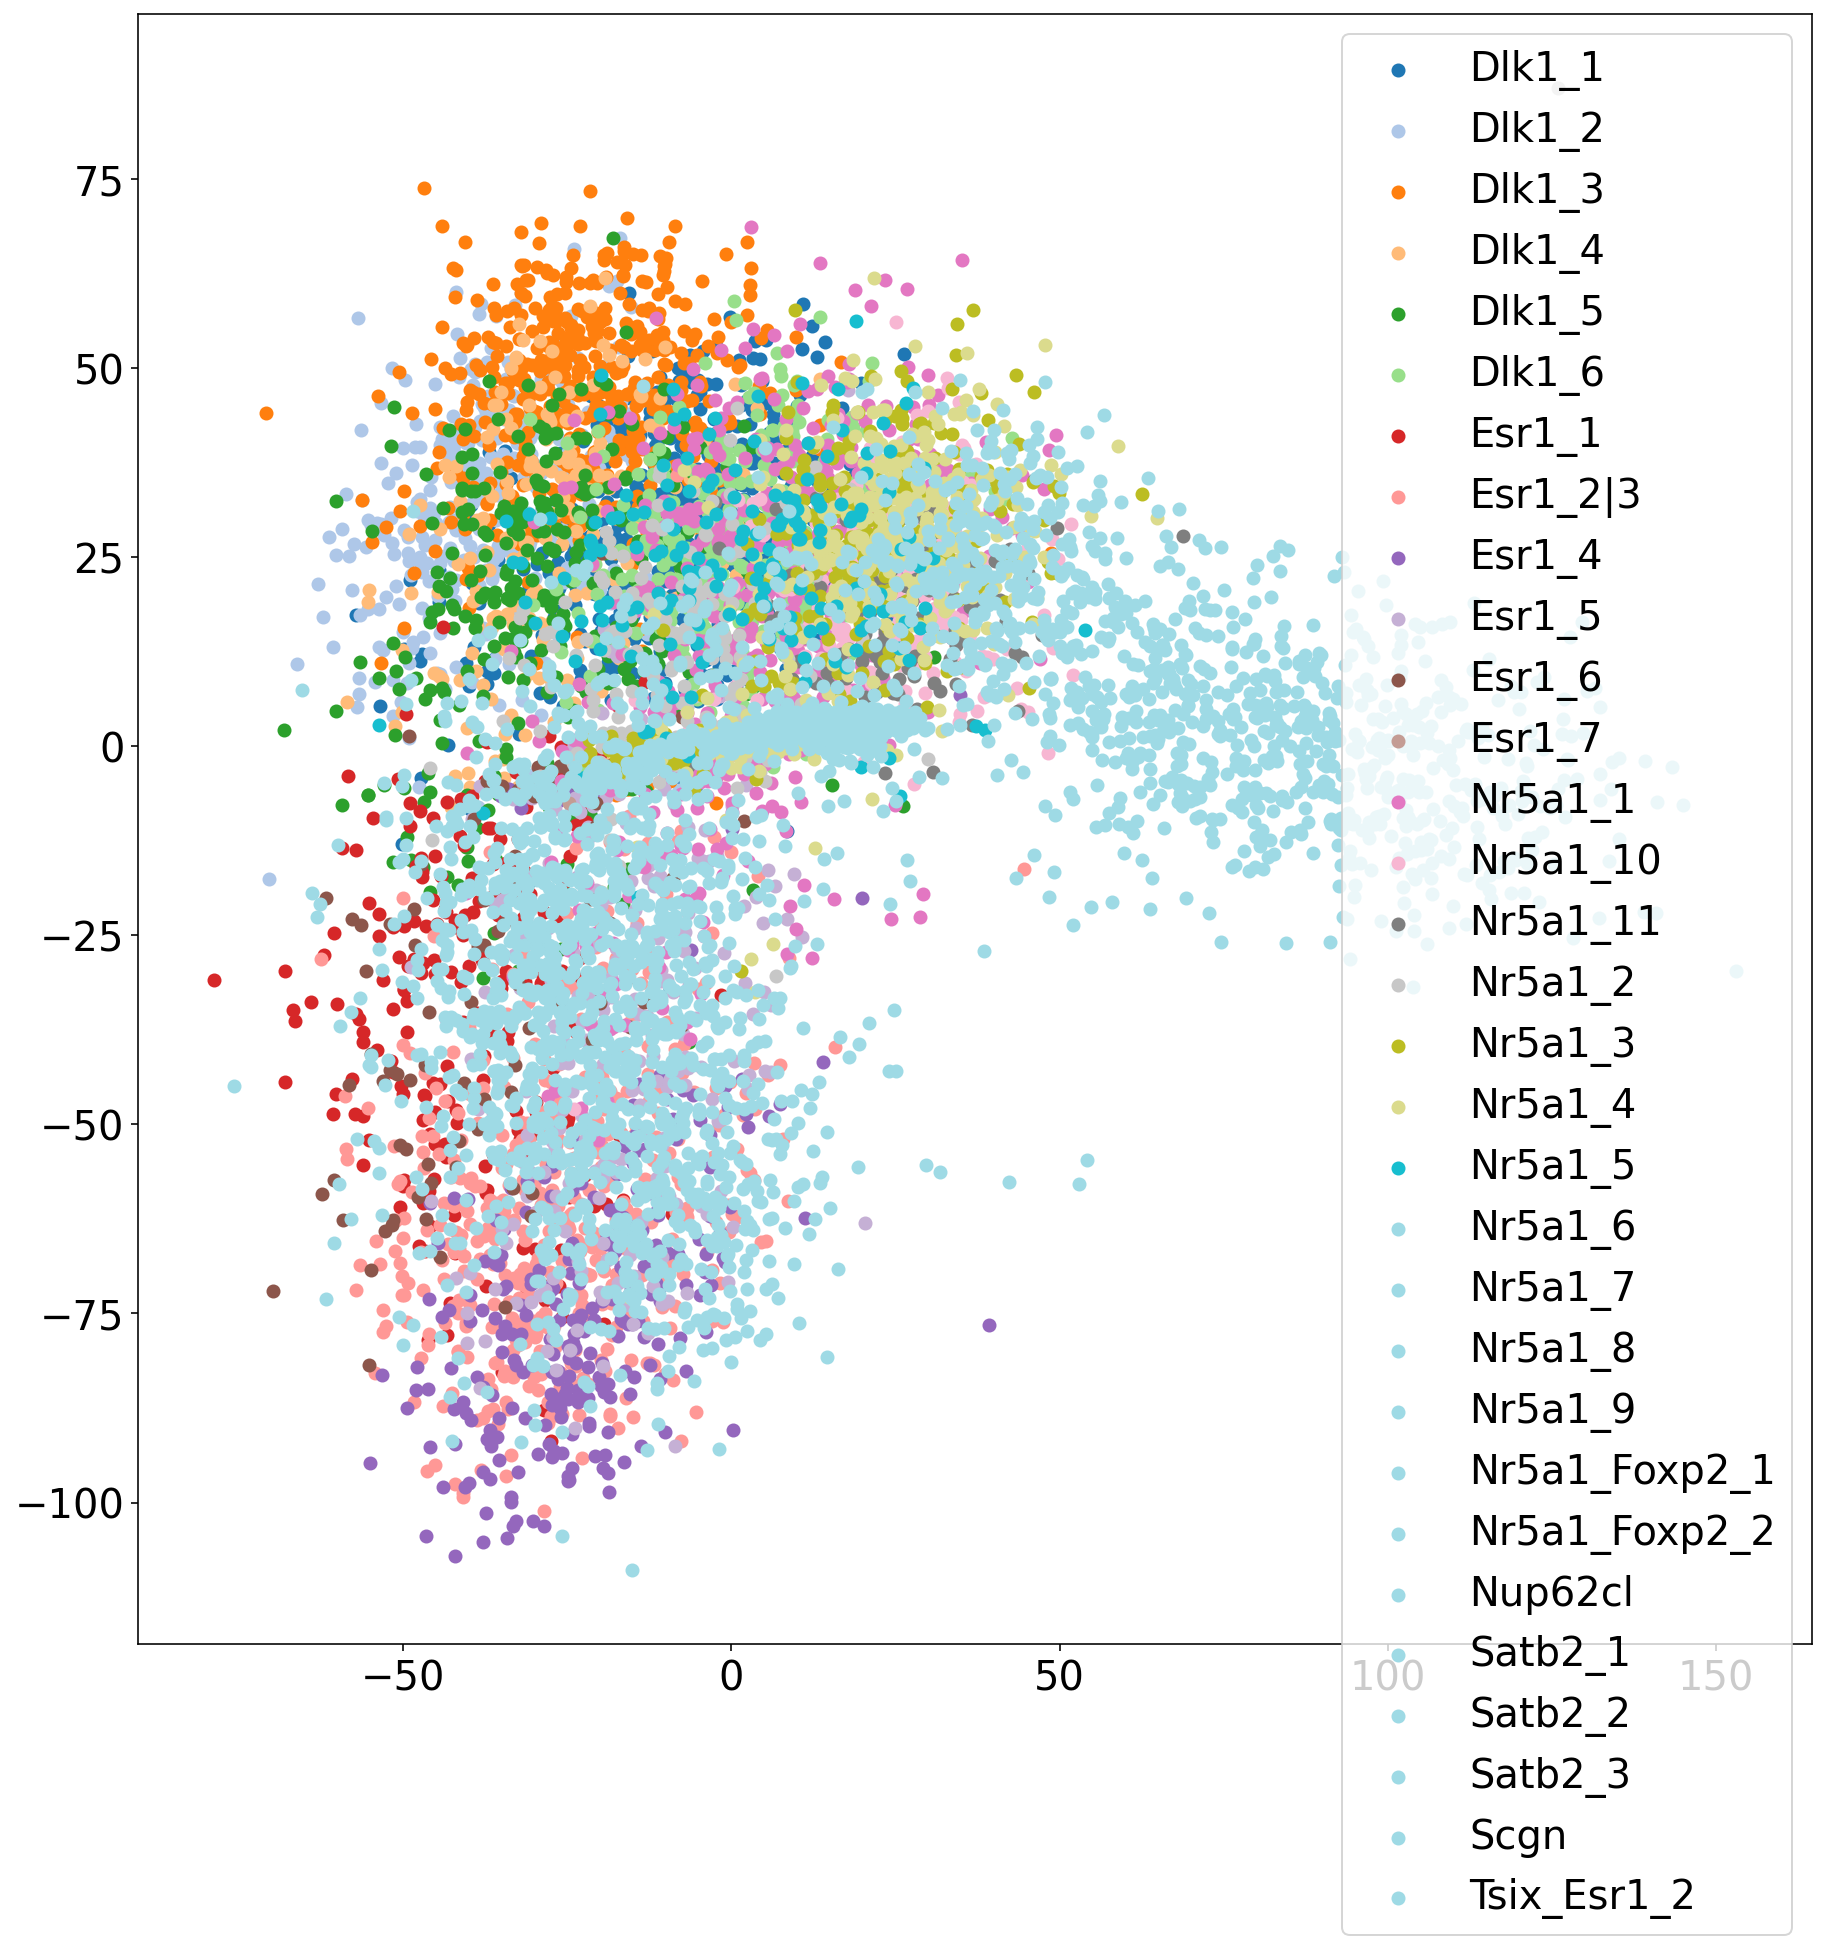

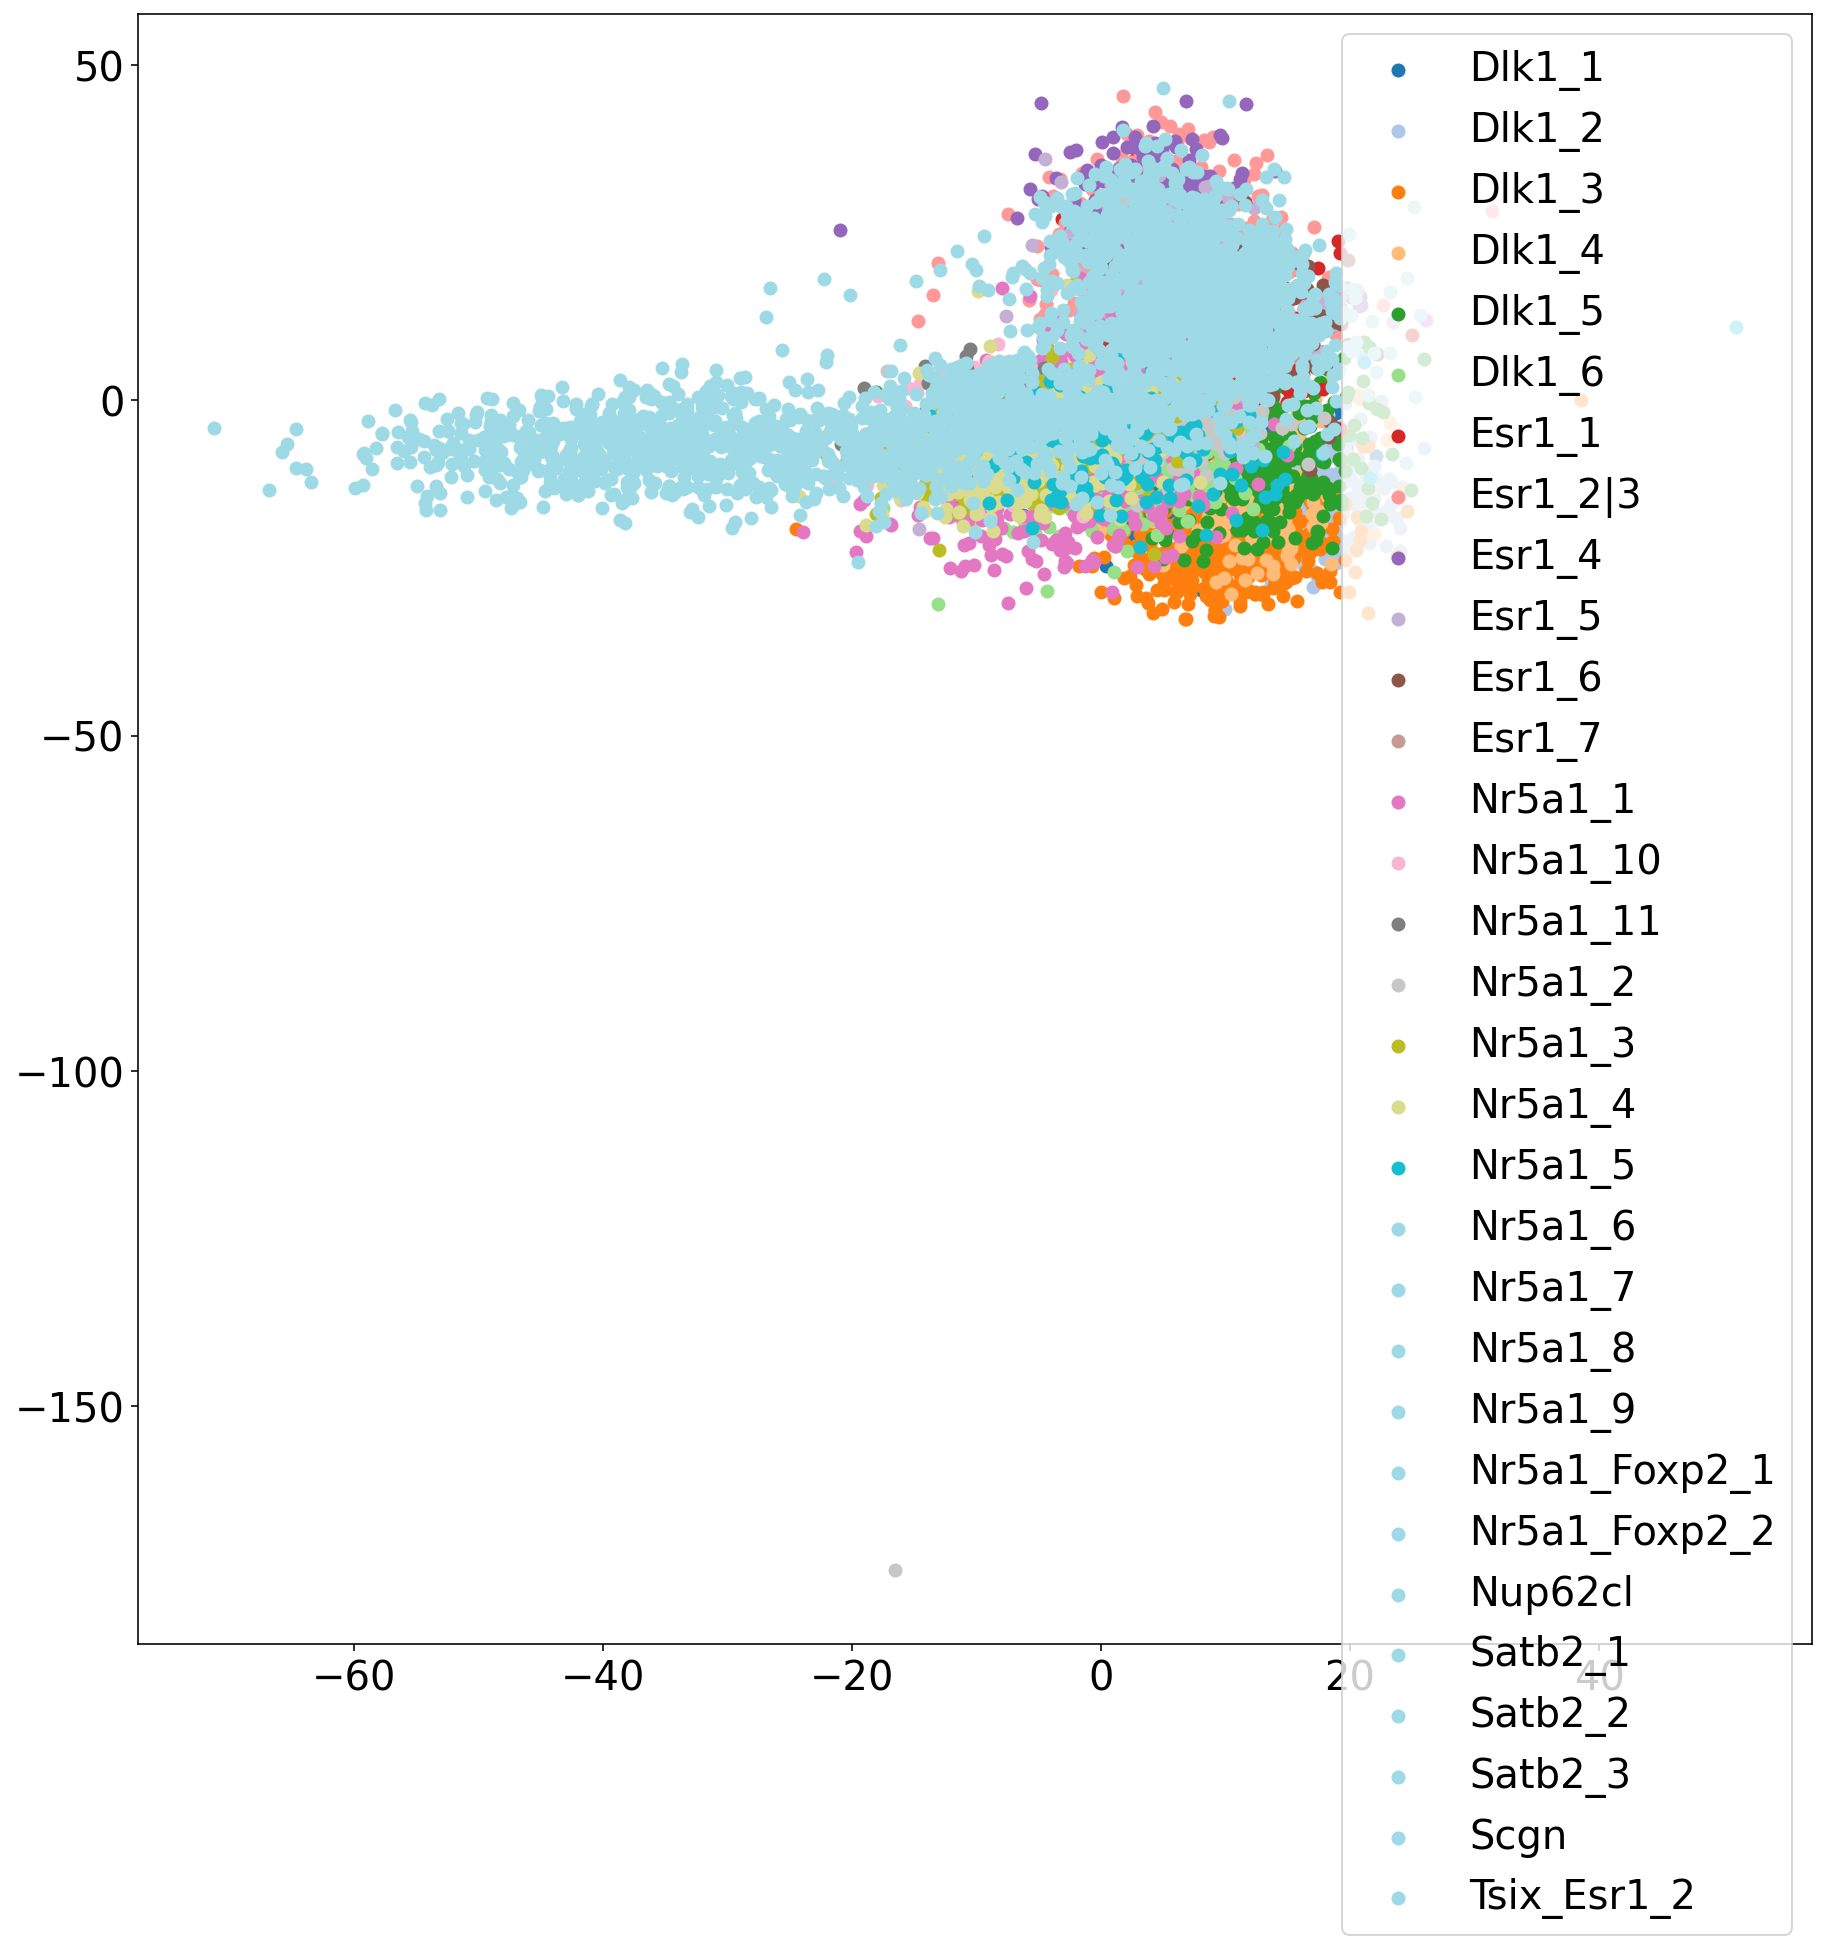

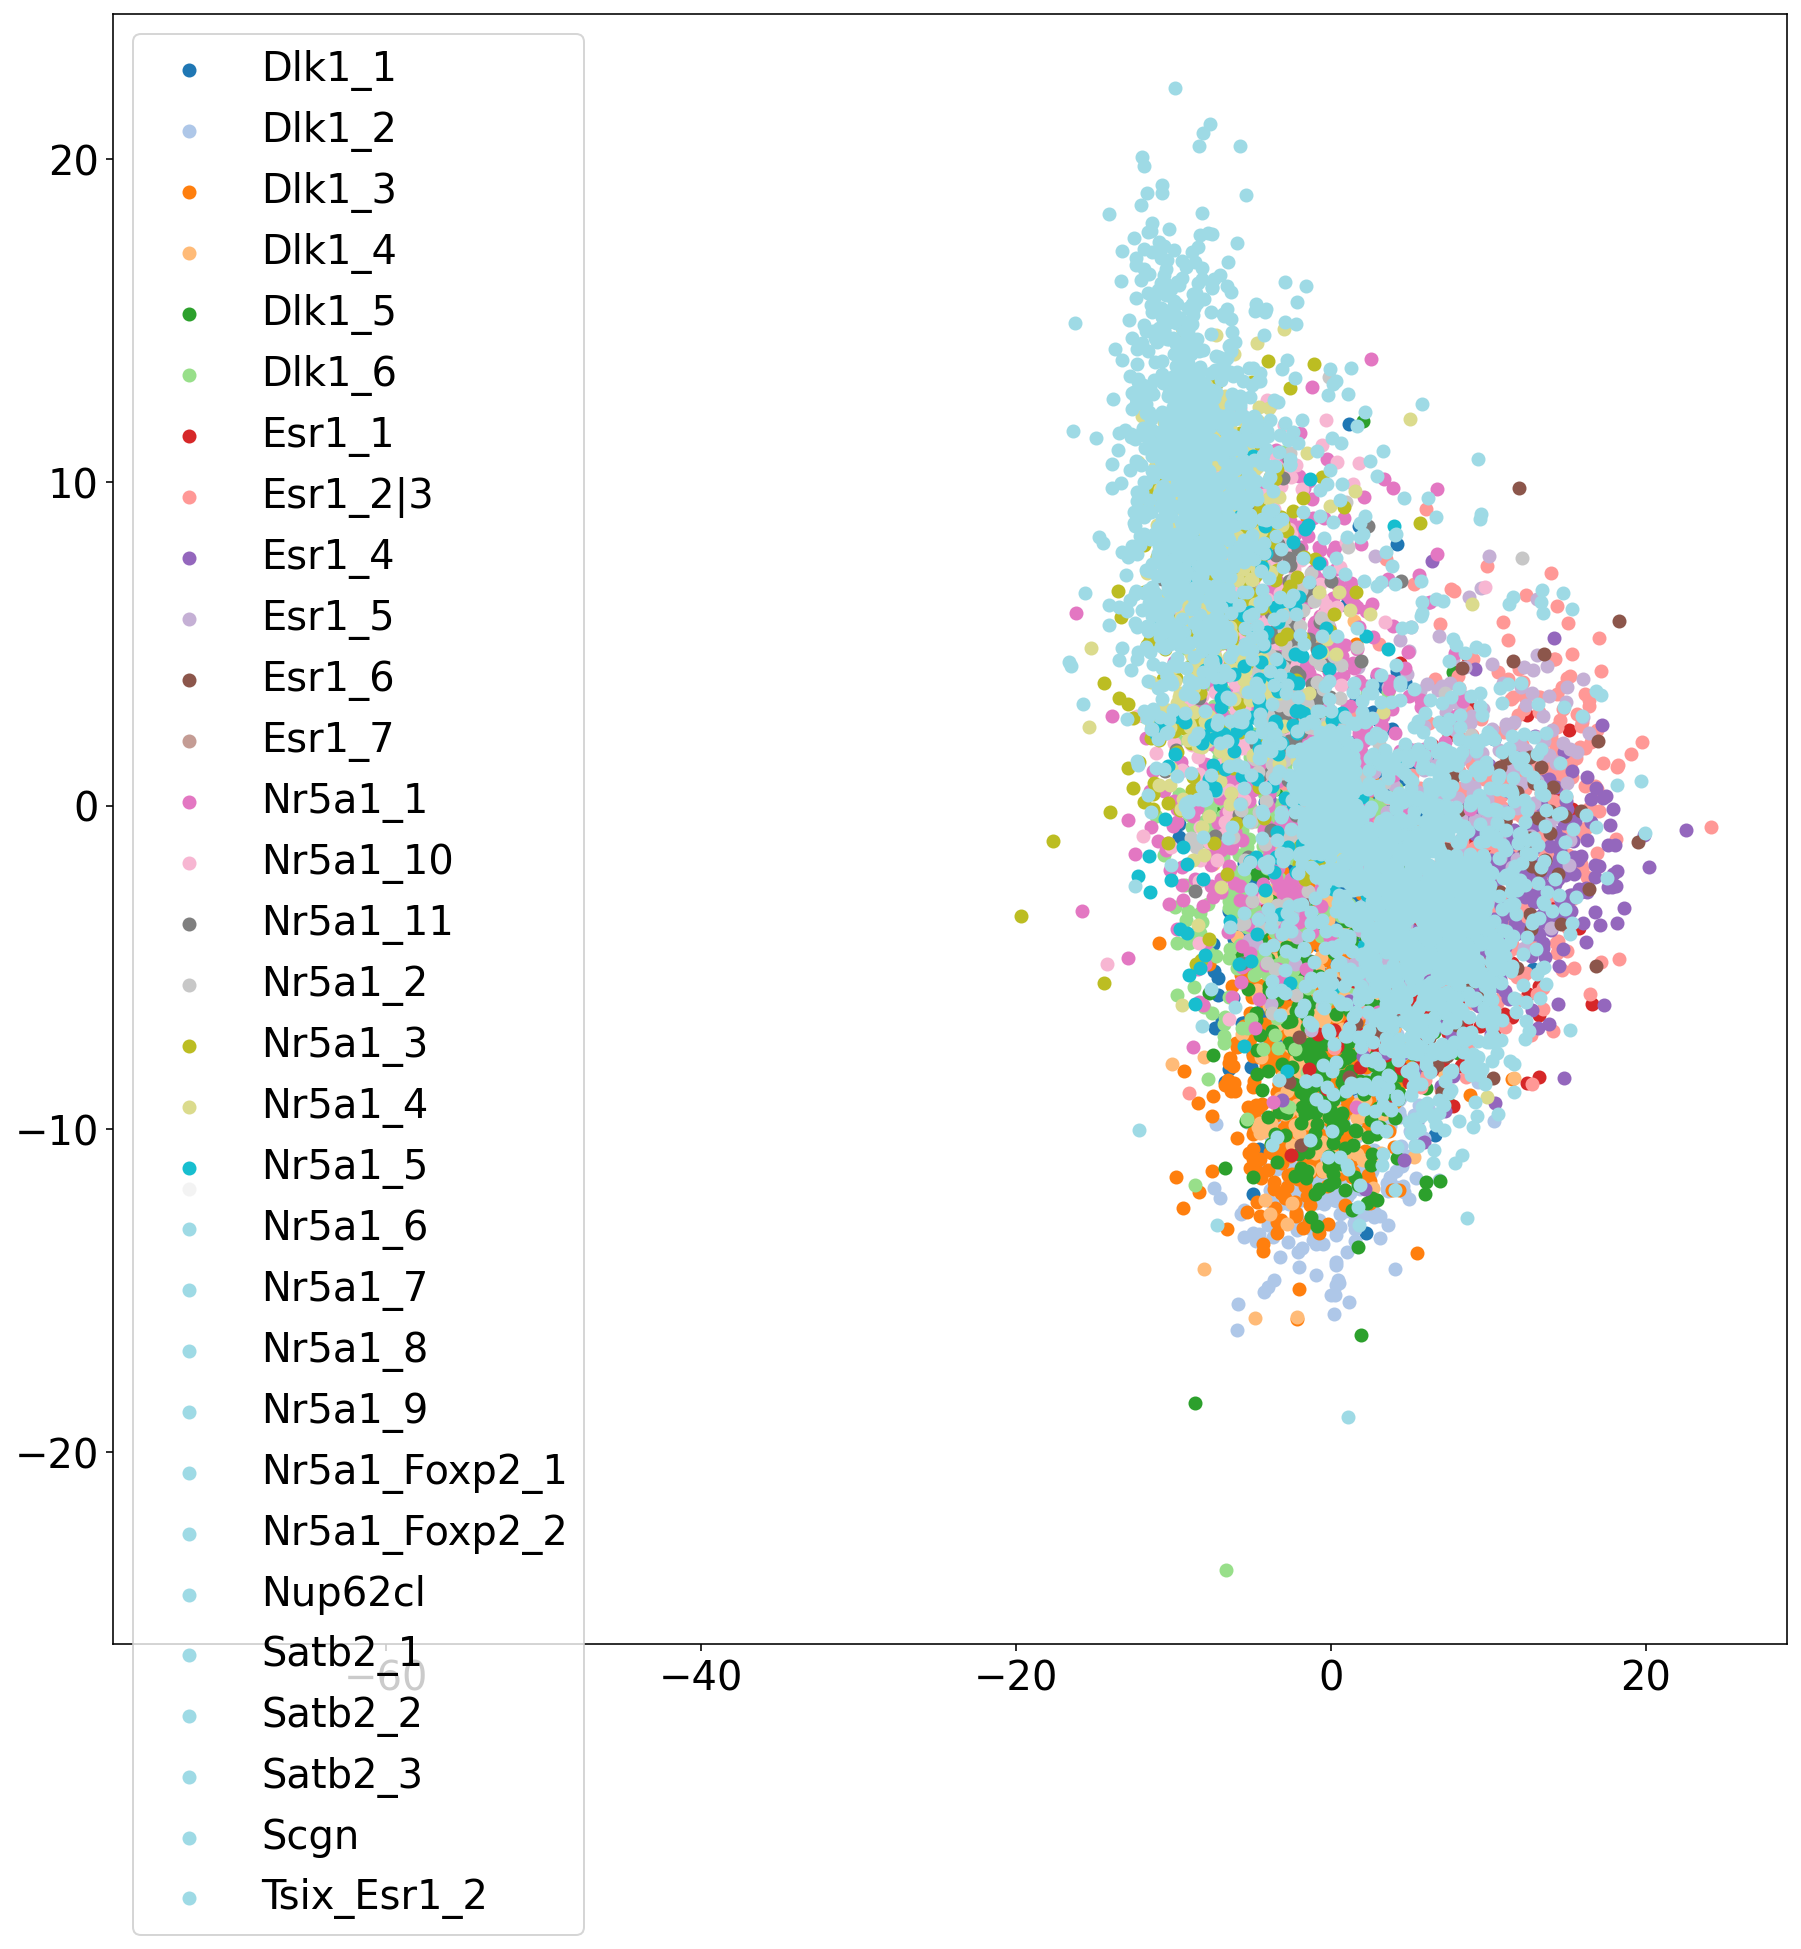

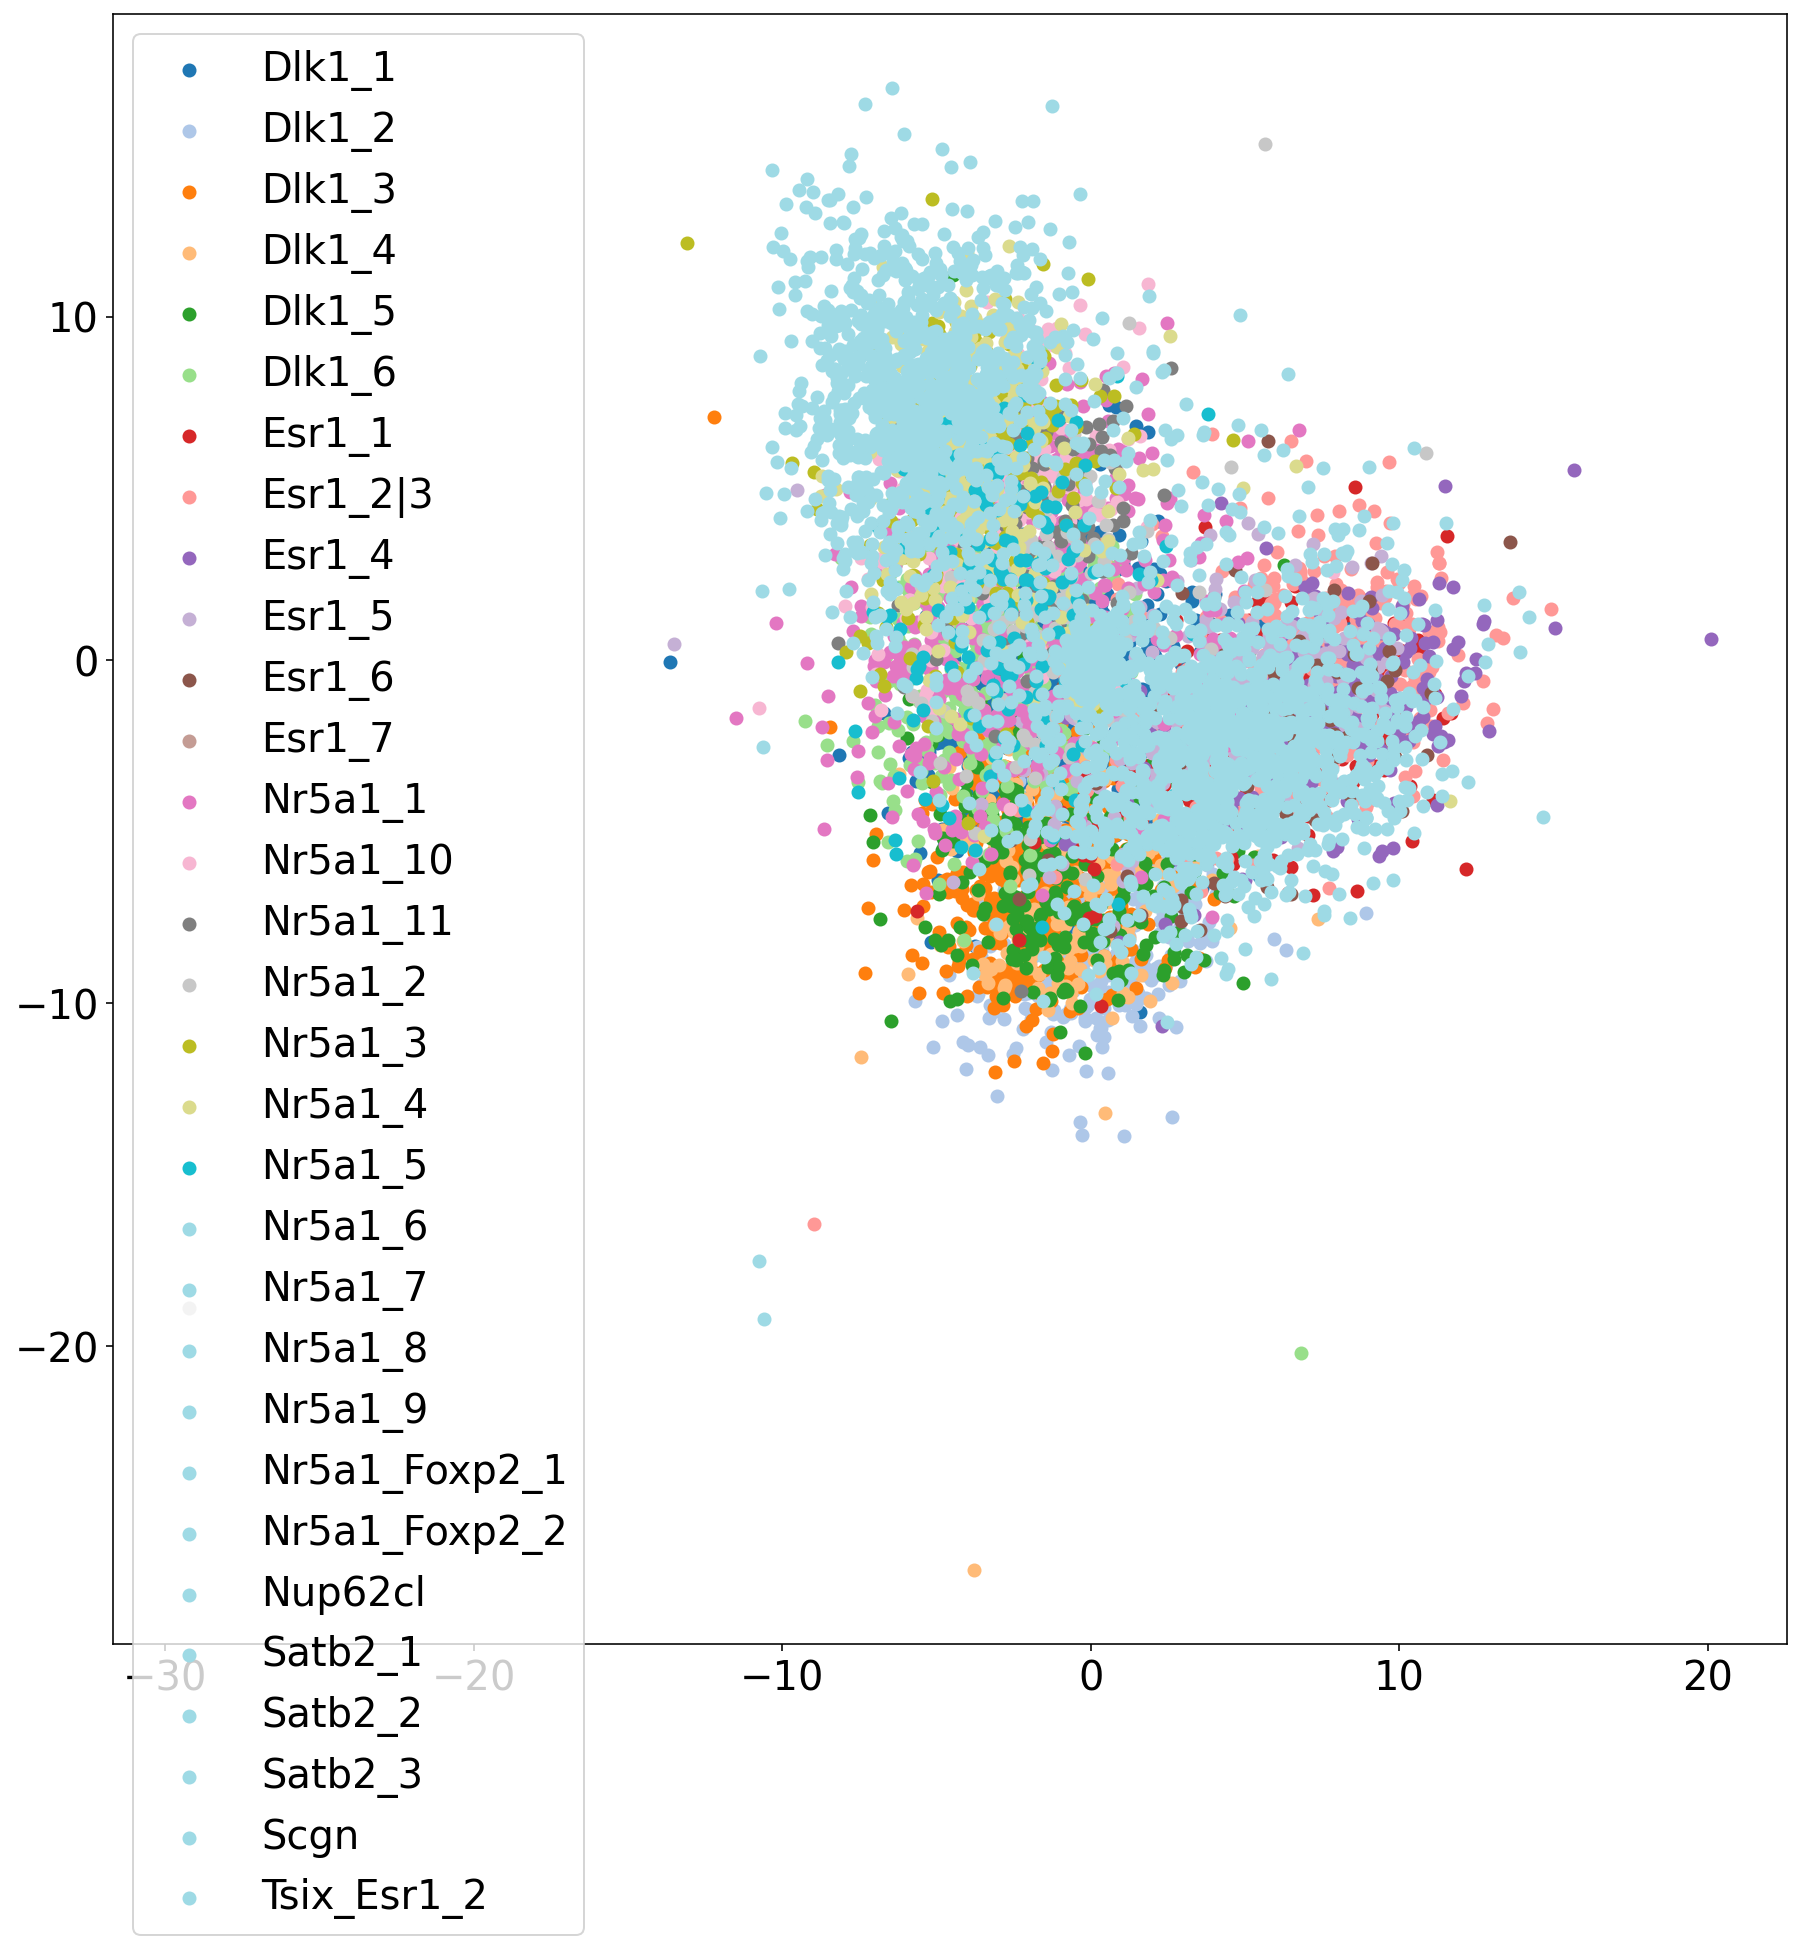

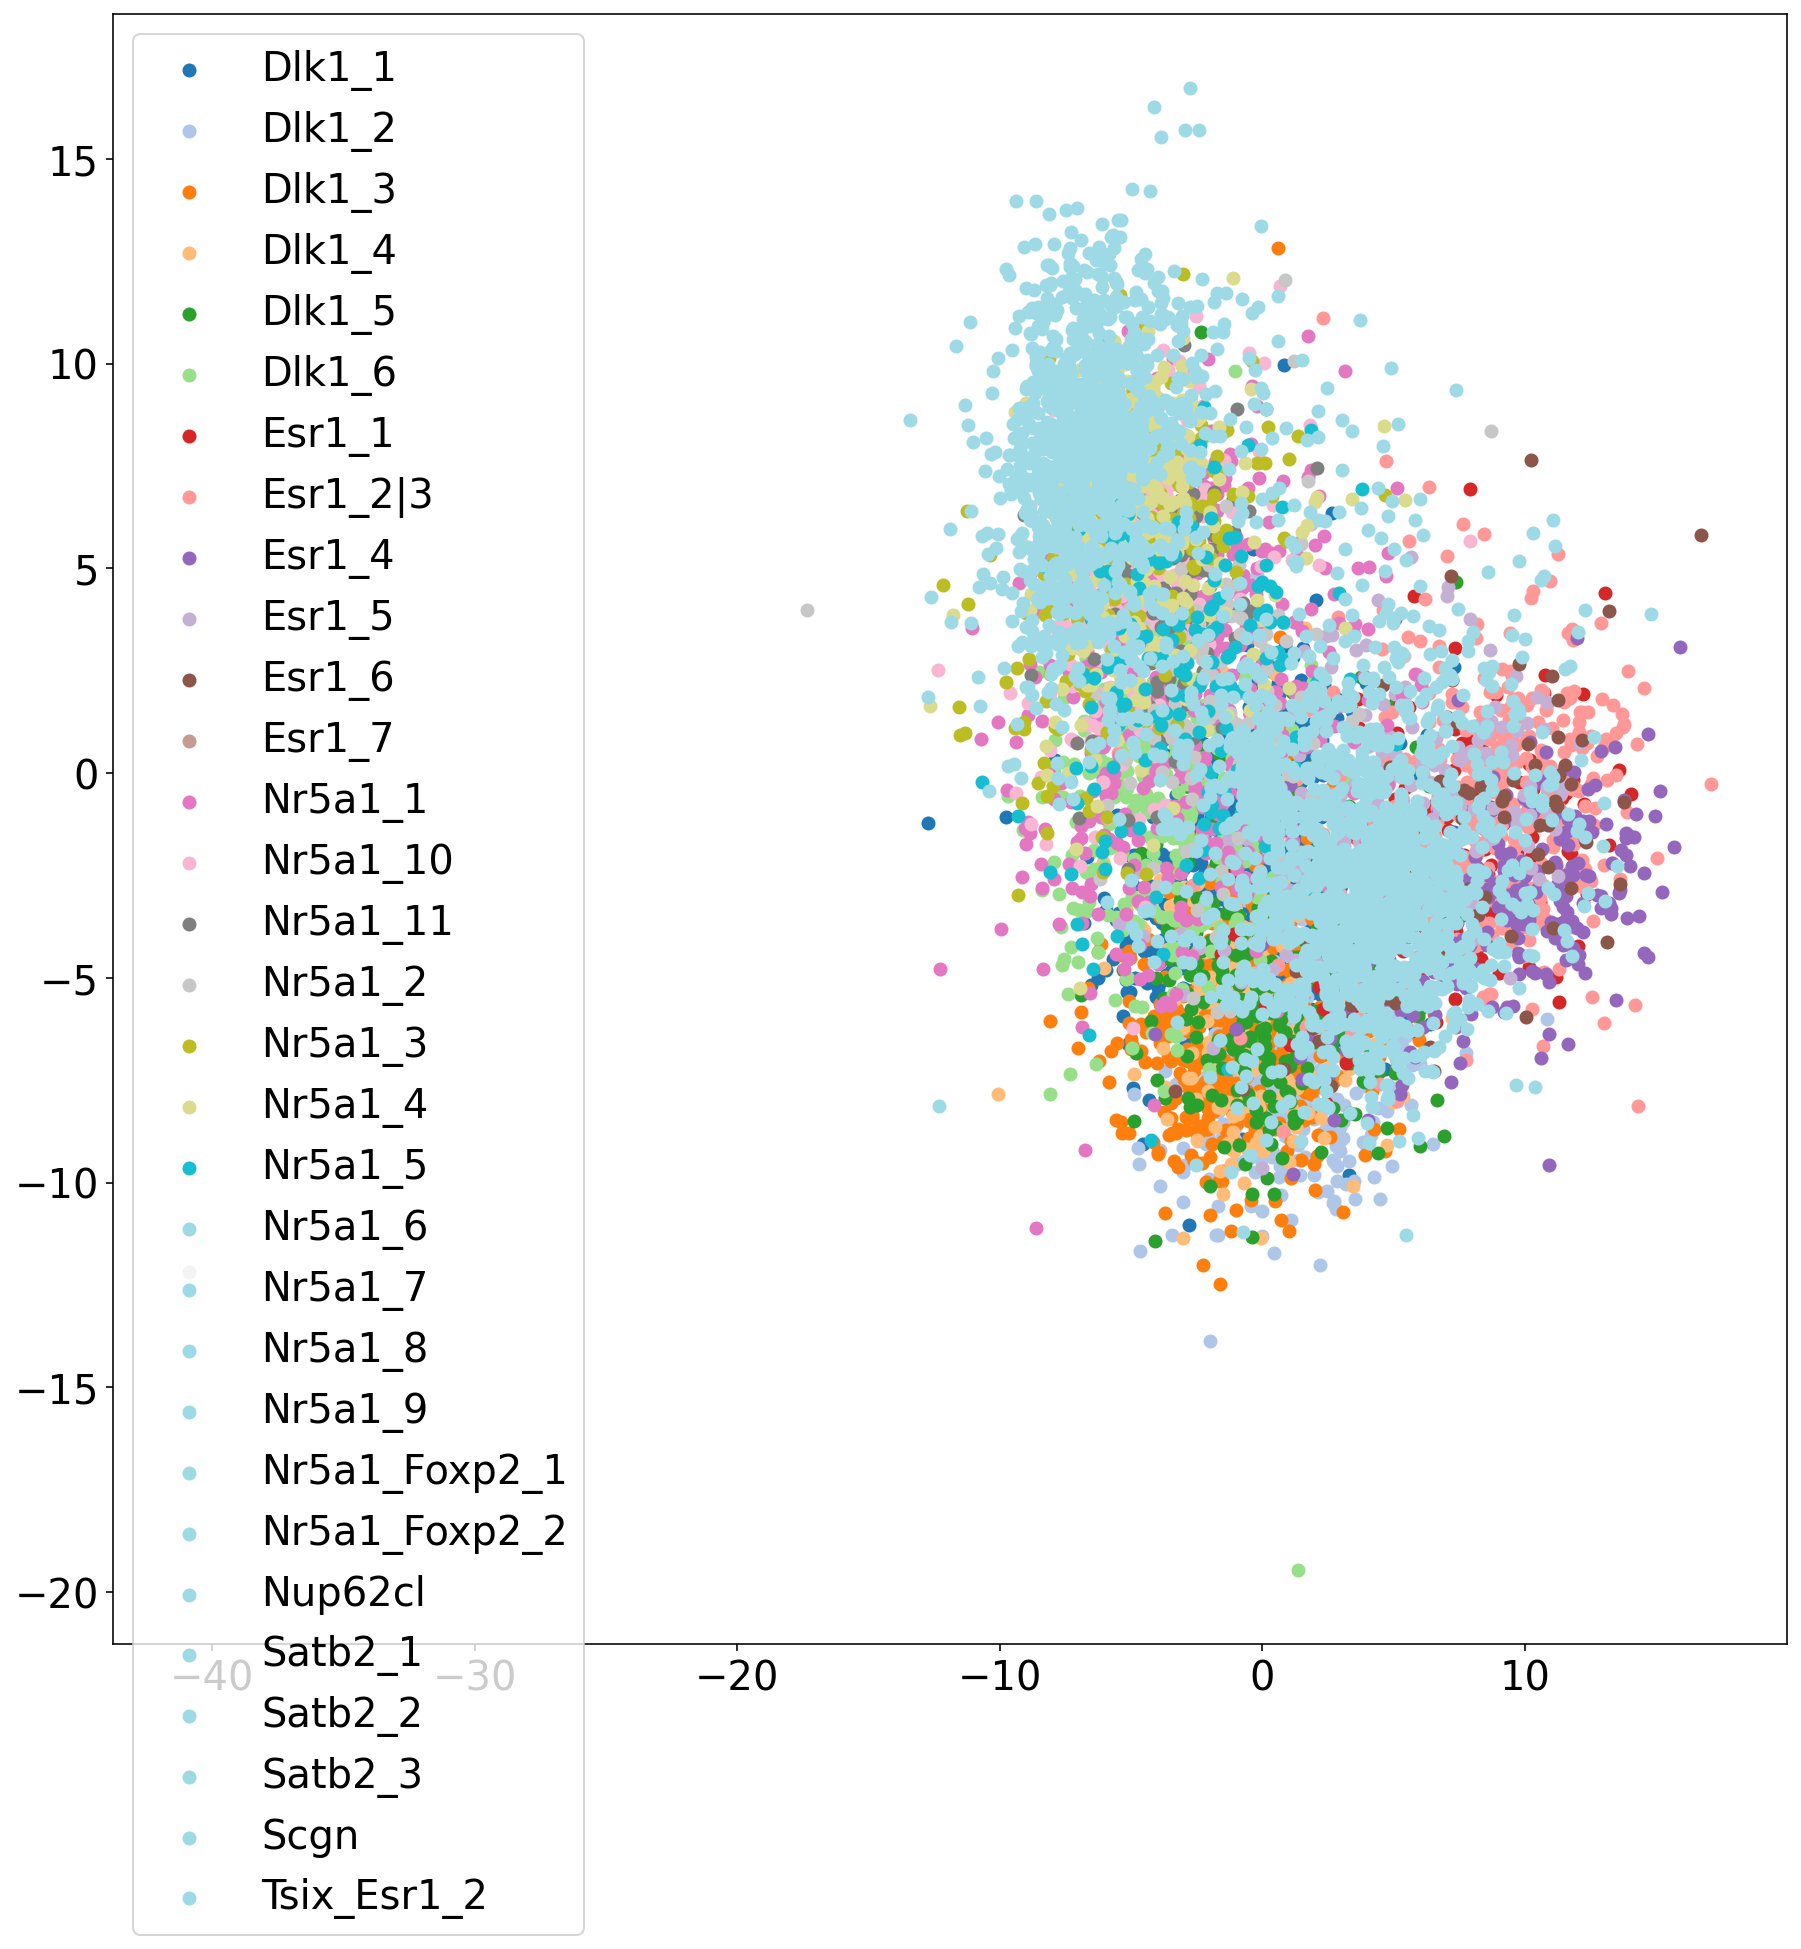

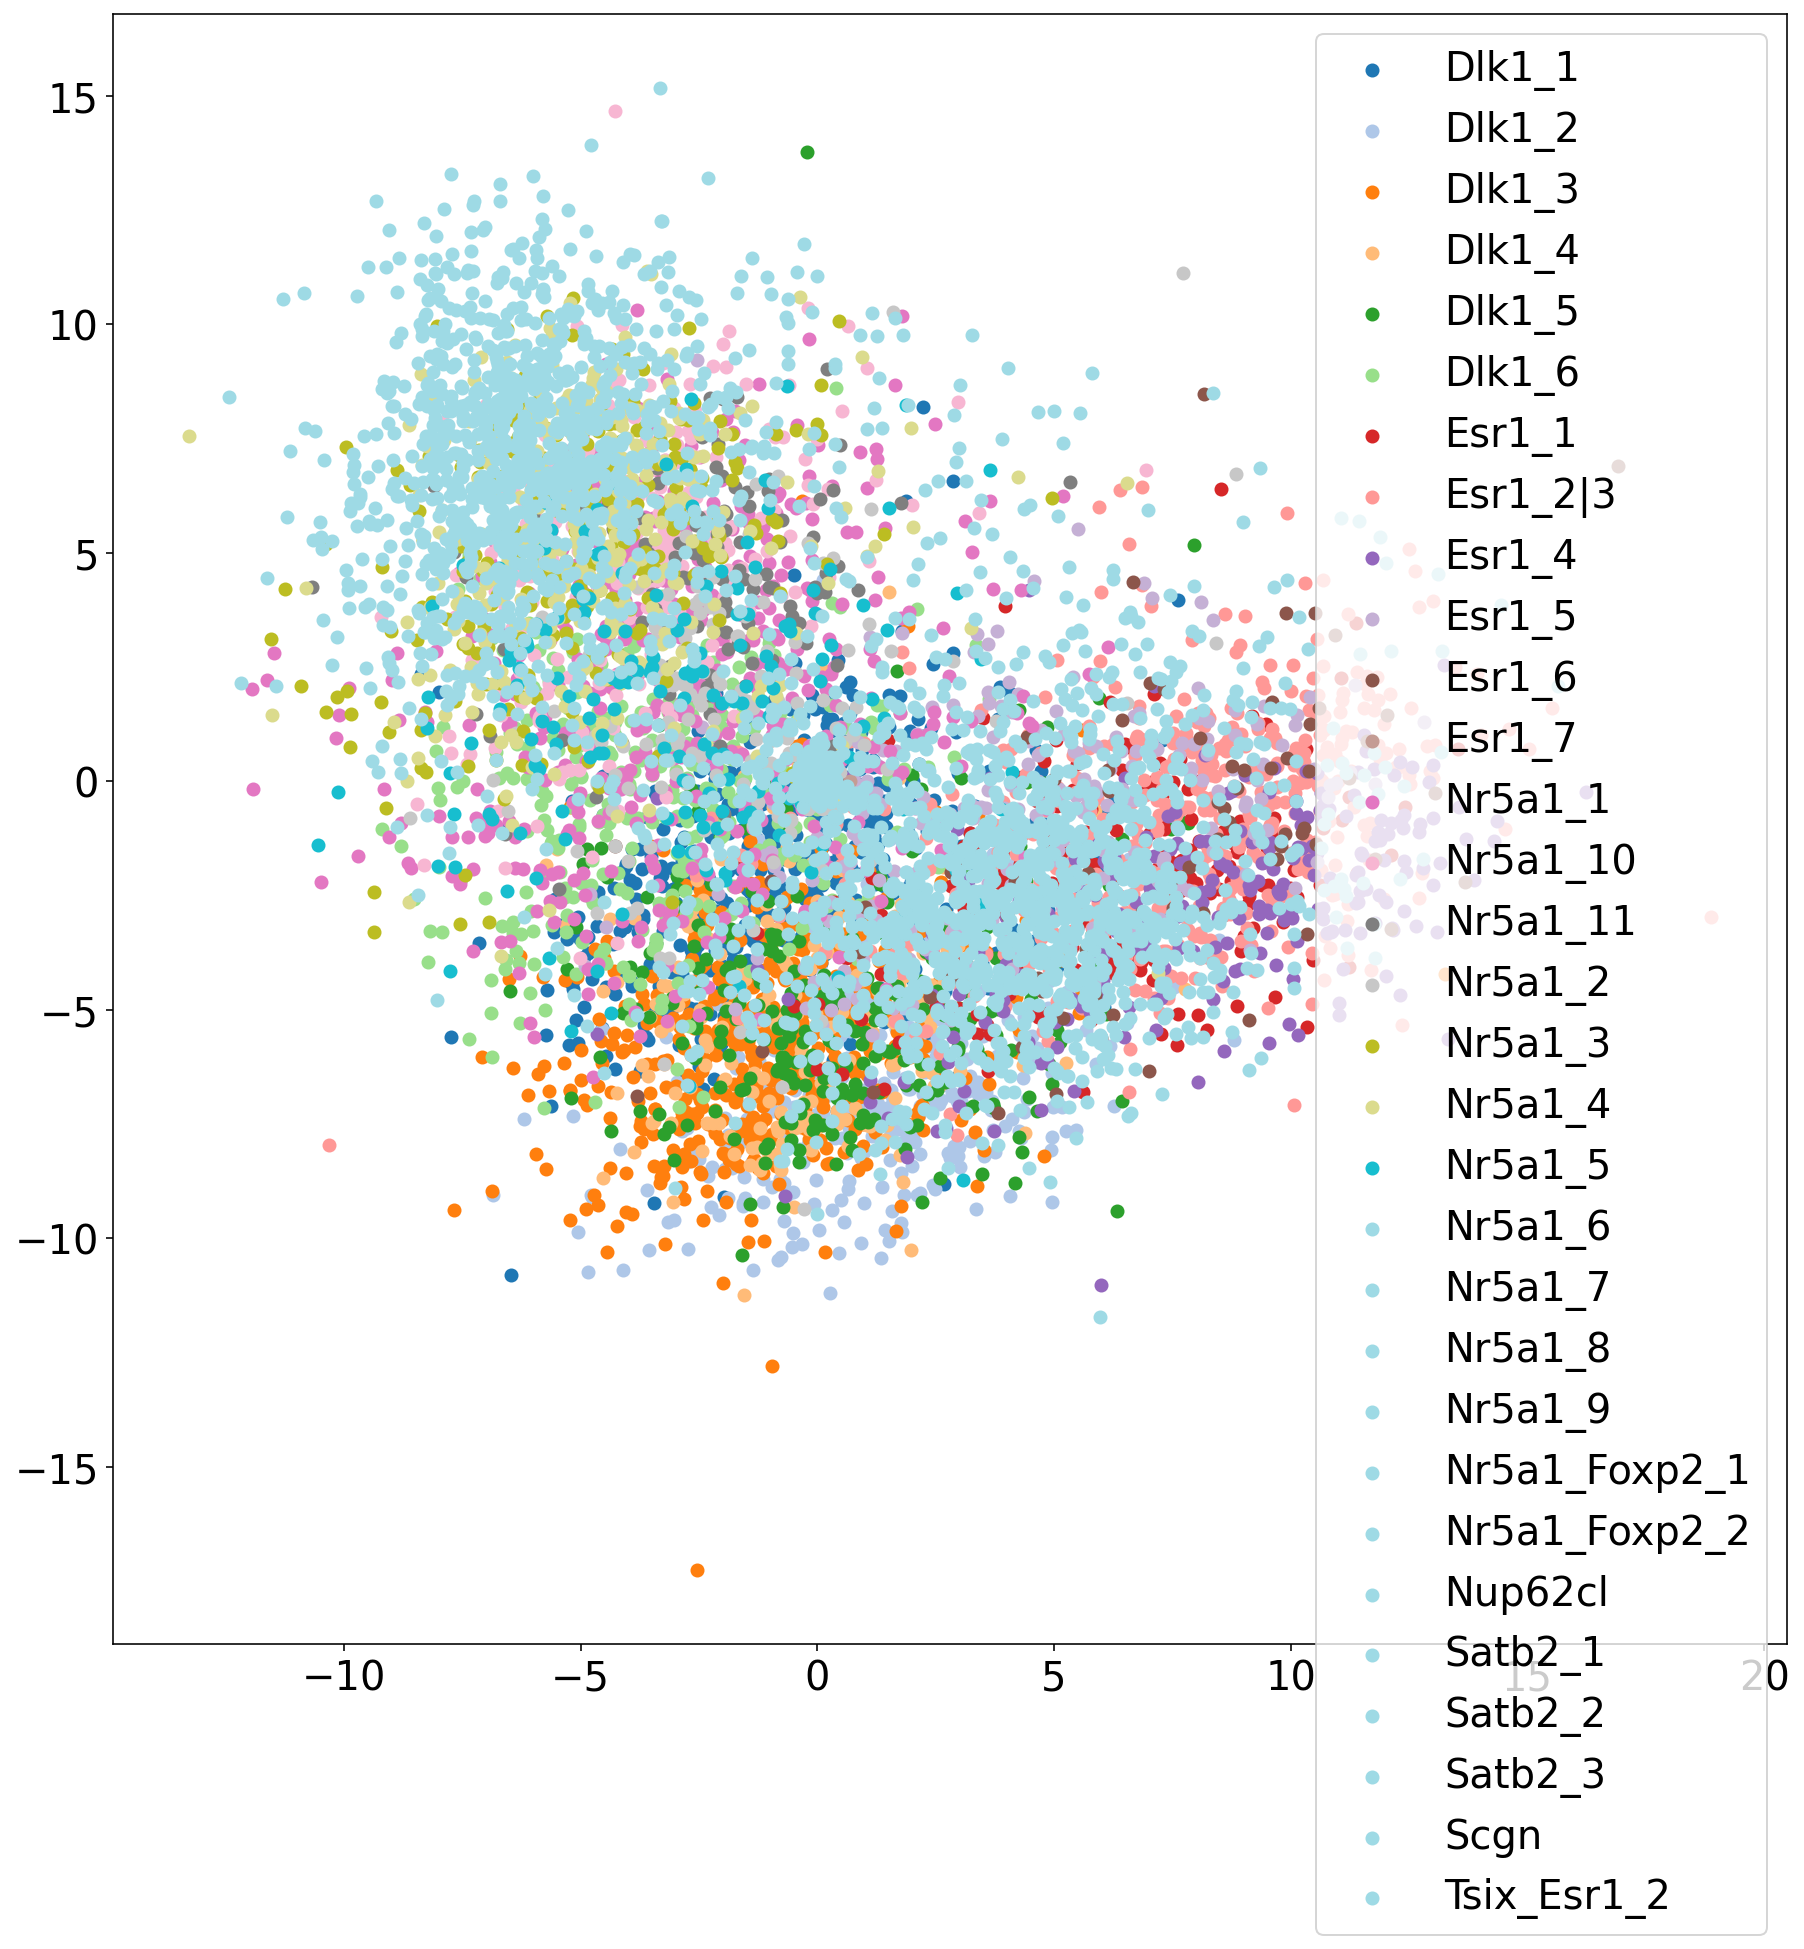

In [53]:
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_10", PCA_dims = 10, ndims = 10)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_20", PCA_dims = 20, ndims = 20)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_30", PCA_dims = 30, ndims = 30)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_40", PCA_dims = 40, ndims = 40)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_50", PCA_dims = 50, ndims = 50)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_60", PCA_dims = 60, ndims = 60)
nc.NCA_analysis(combined, "cca_cluster", "cca_cluster", out_label = "NCA_10_PCA_70", PCA_dims = 70, ndims = 70)

In [54]:
NCA_dists_10D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_10")
NCA_dists_20D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_20")
NCA_dists_30D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_30")
NCA_dists_40D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_40")
NCA_dists_50D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_50")
NCA_dists_60D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_60")
NCA_dists_70D = nc.distance_from_centroid(combined, "cca_cluster", nca_label="NCA_10_PCA_70")

In [61]:
NCA_no_PCA = nc.distance_from_centroid(combined, "cca_cluster", nca_label = "NCA_no_PCA")

In [55]:
NCA_dists = [NCA_dists_10D, NCA_dists_20D, NCA_dists_30D, NCA_dists_40D, NCA_dists_50D, NCA_dists_60D, NCA_dists_70D]

In [58]:
x = np.linspace(0.0, 200.0, num = 100)

Text(0.5, 1.0, 'Centroid Distances in NCA Space w/ diff PCA dims')

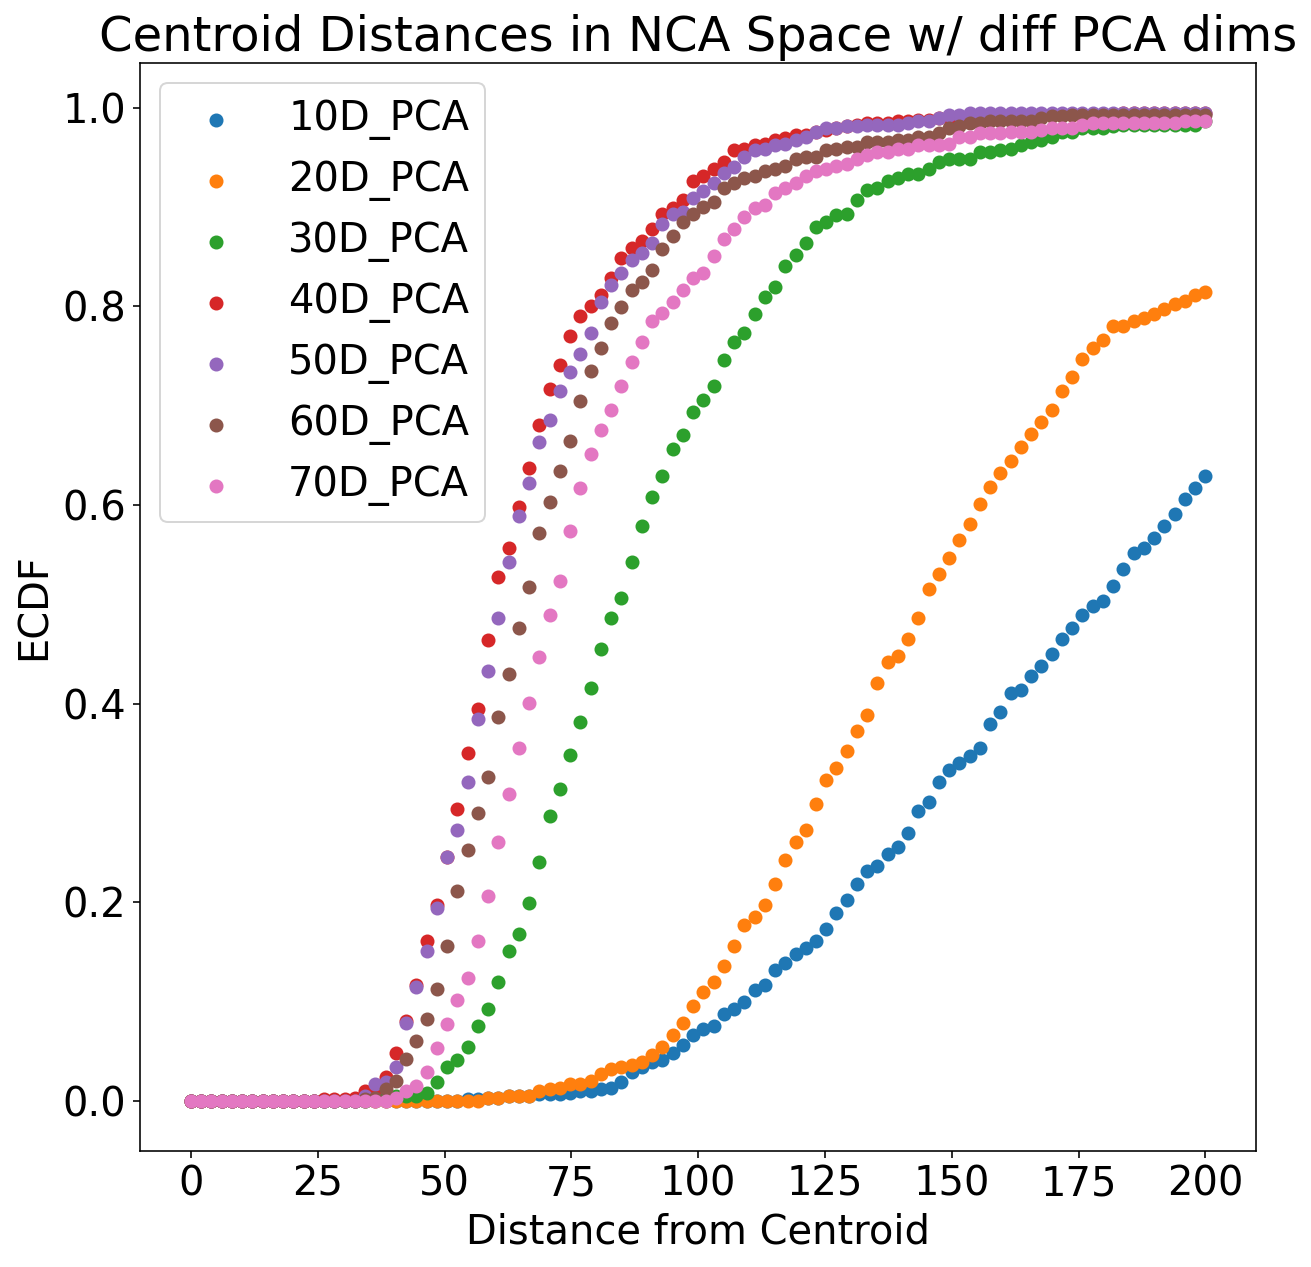

In [60]:
fig, ax = plt.subplots(figsize = (10, 10))
for i, data in enumerate(NCA_dists):
    y = nc.ecdf(x, list(data.values())[0][0])
    ax.scatter(x, y, label = str(10*(i + 1)) + "D_PCA")
ax.legend()
ax.set_xlabel("Distance from Centroid")
ax.set_ylabel("ECDF")
plt.title("Centroid Distances in NCA Space w/ diff PCA dims")

Text(0, 0.5, 'ECDF')

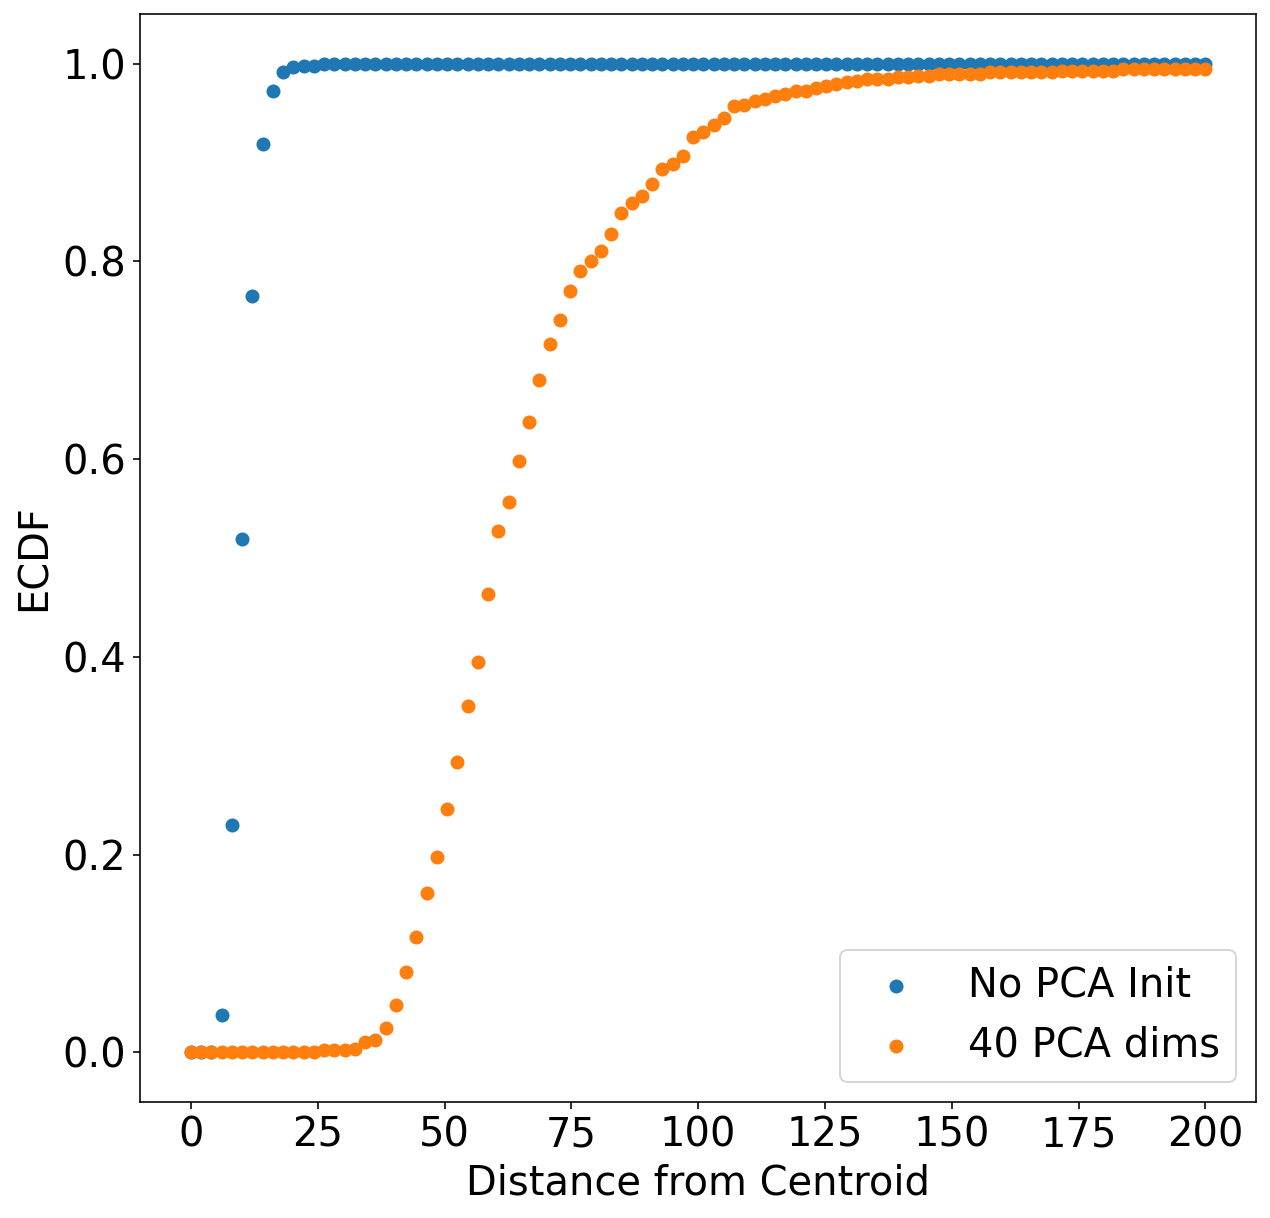

In [64]:
fig, ax = plt.subplots(figsize = (10, 10))
y1 = nc.ecdf(x, list(NCA_10D_dists.values())[0][0])
ax.scatter(x, y1, label = "No PCA Init")
y2 = nc.ecdf(x, list(NCA_dists_40D.values())[0][0])
ax.scatter(x, y2, label = "40 PCA dims")
ax.legend()
ax.set_xlabel("Distance from Centroid")
ax.set_ylabel("ECDF")

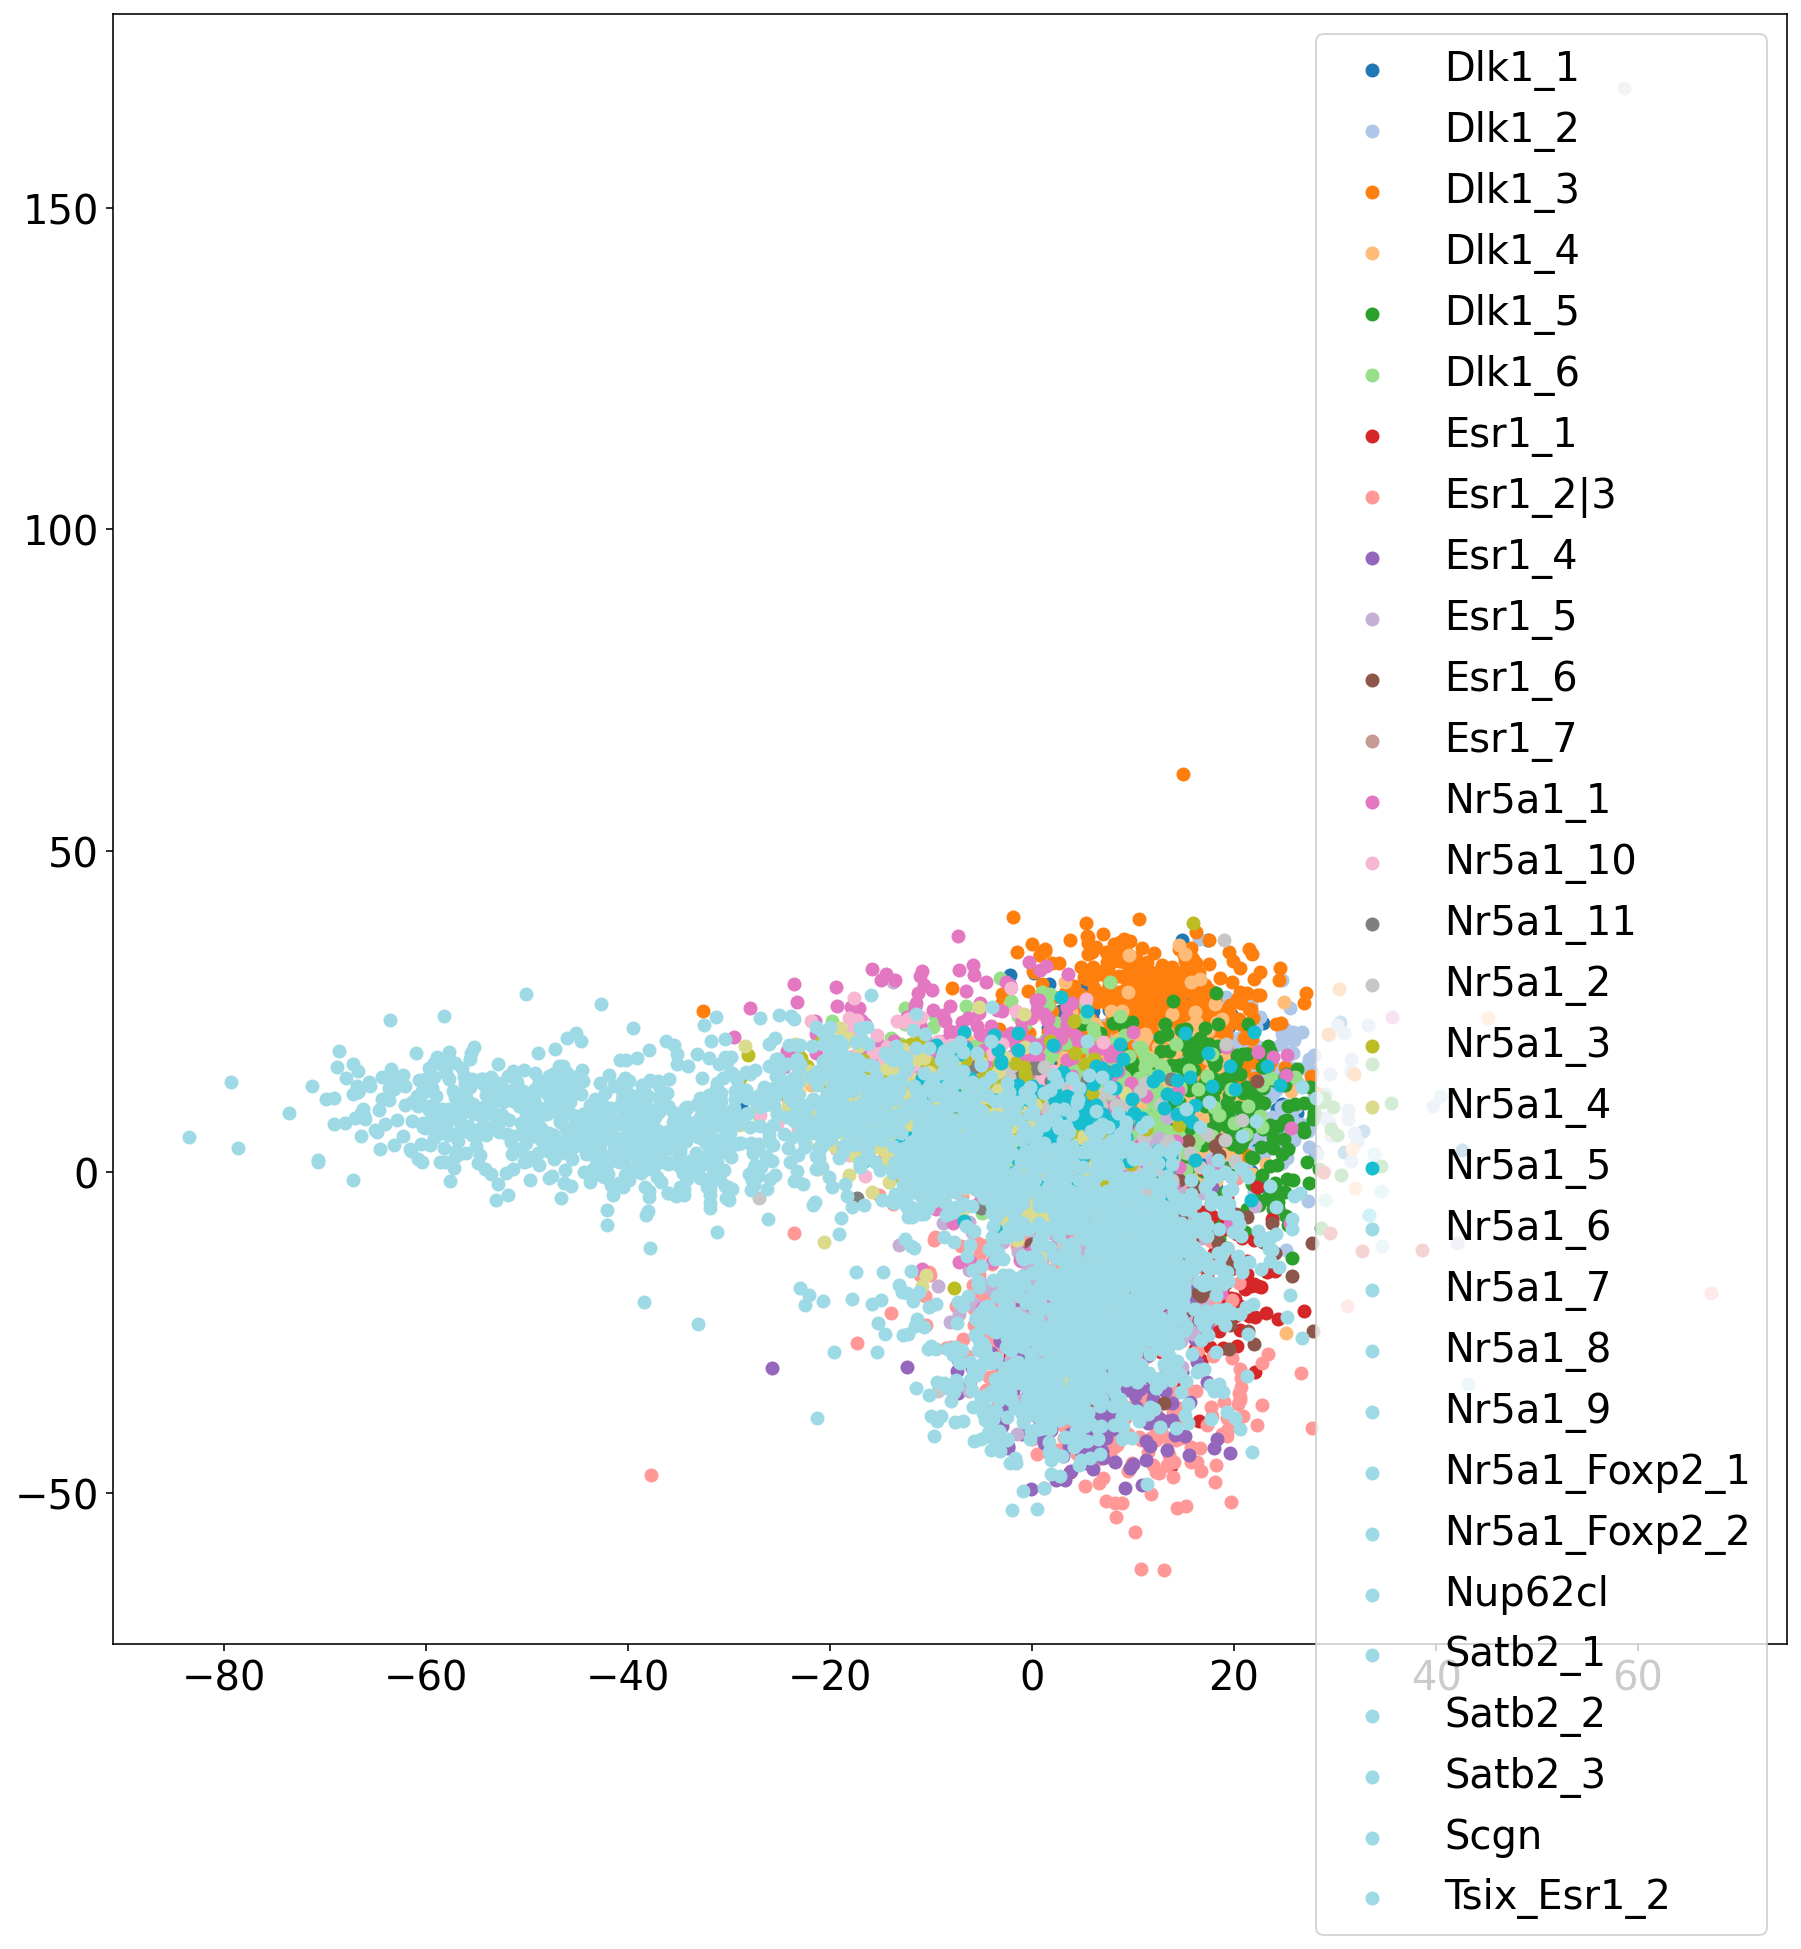

In [71]:
nc.NCA_analysis(combined, ["cca_cluster", "sex_label"], "cca_cluster", ndims = 10, PCA_dims = 50, out_label = "NCA_sex_label")

In [72]:
NCA_cca_only = nc.distance_from_centroid(combined, "cca_cluster", nca_label = "NCA_cca_only")
NCA_w_sex_label = nc.distance_from_centroid(combined, "cca_cluster", nca_label = "NCA_sex_label")

Text(0, 0.5, 'ECDF')

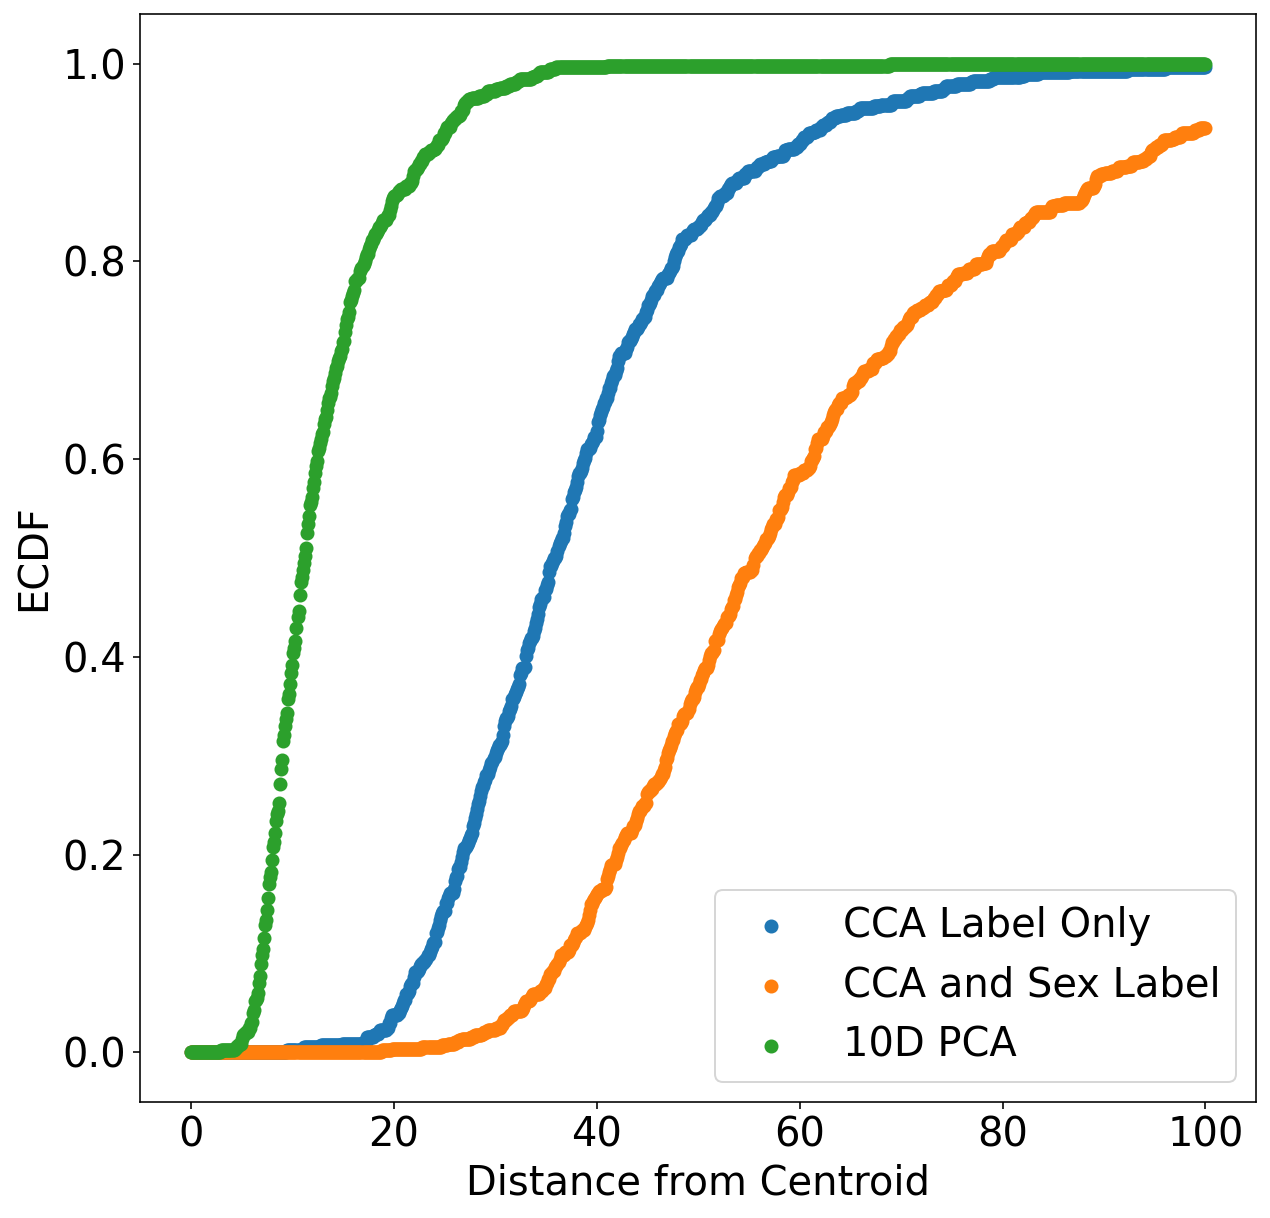

In [74]:
x = np.linspace(0, 100, num=1000)
fig, ax = plt.subplots(figsize = (10, 10))
y1 = nc.ecdf(x, list(NCA_cca_only.values())[0][0])
y2 = nc.ecdf(x, list(NCA_w_sex_label.values())[0][0])
y3 = nc.ecdf(x, list(PCA_dists_10D.values())[0][0])
ax.scatter(x, y1, label = "CCA Label Only")
ax.scatter(x, y2, label = "CCA and Sex Label")
ax.scatter(x, y3, label = "10D PCA")
ax.legend()
ax.set_xlabel("Distance from Centroid")
ax.set_ylabel("ECDF")

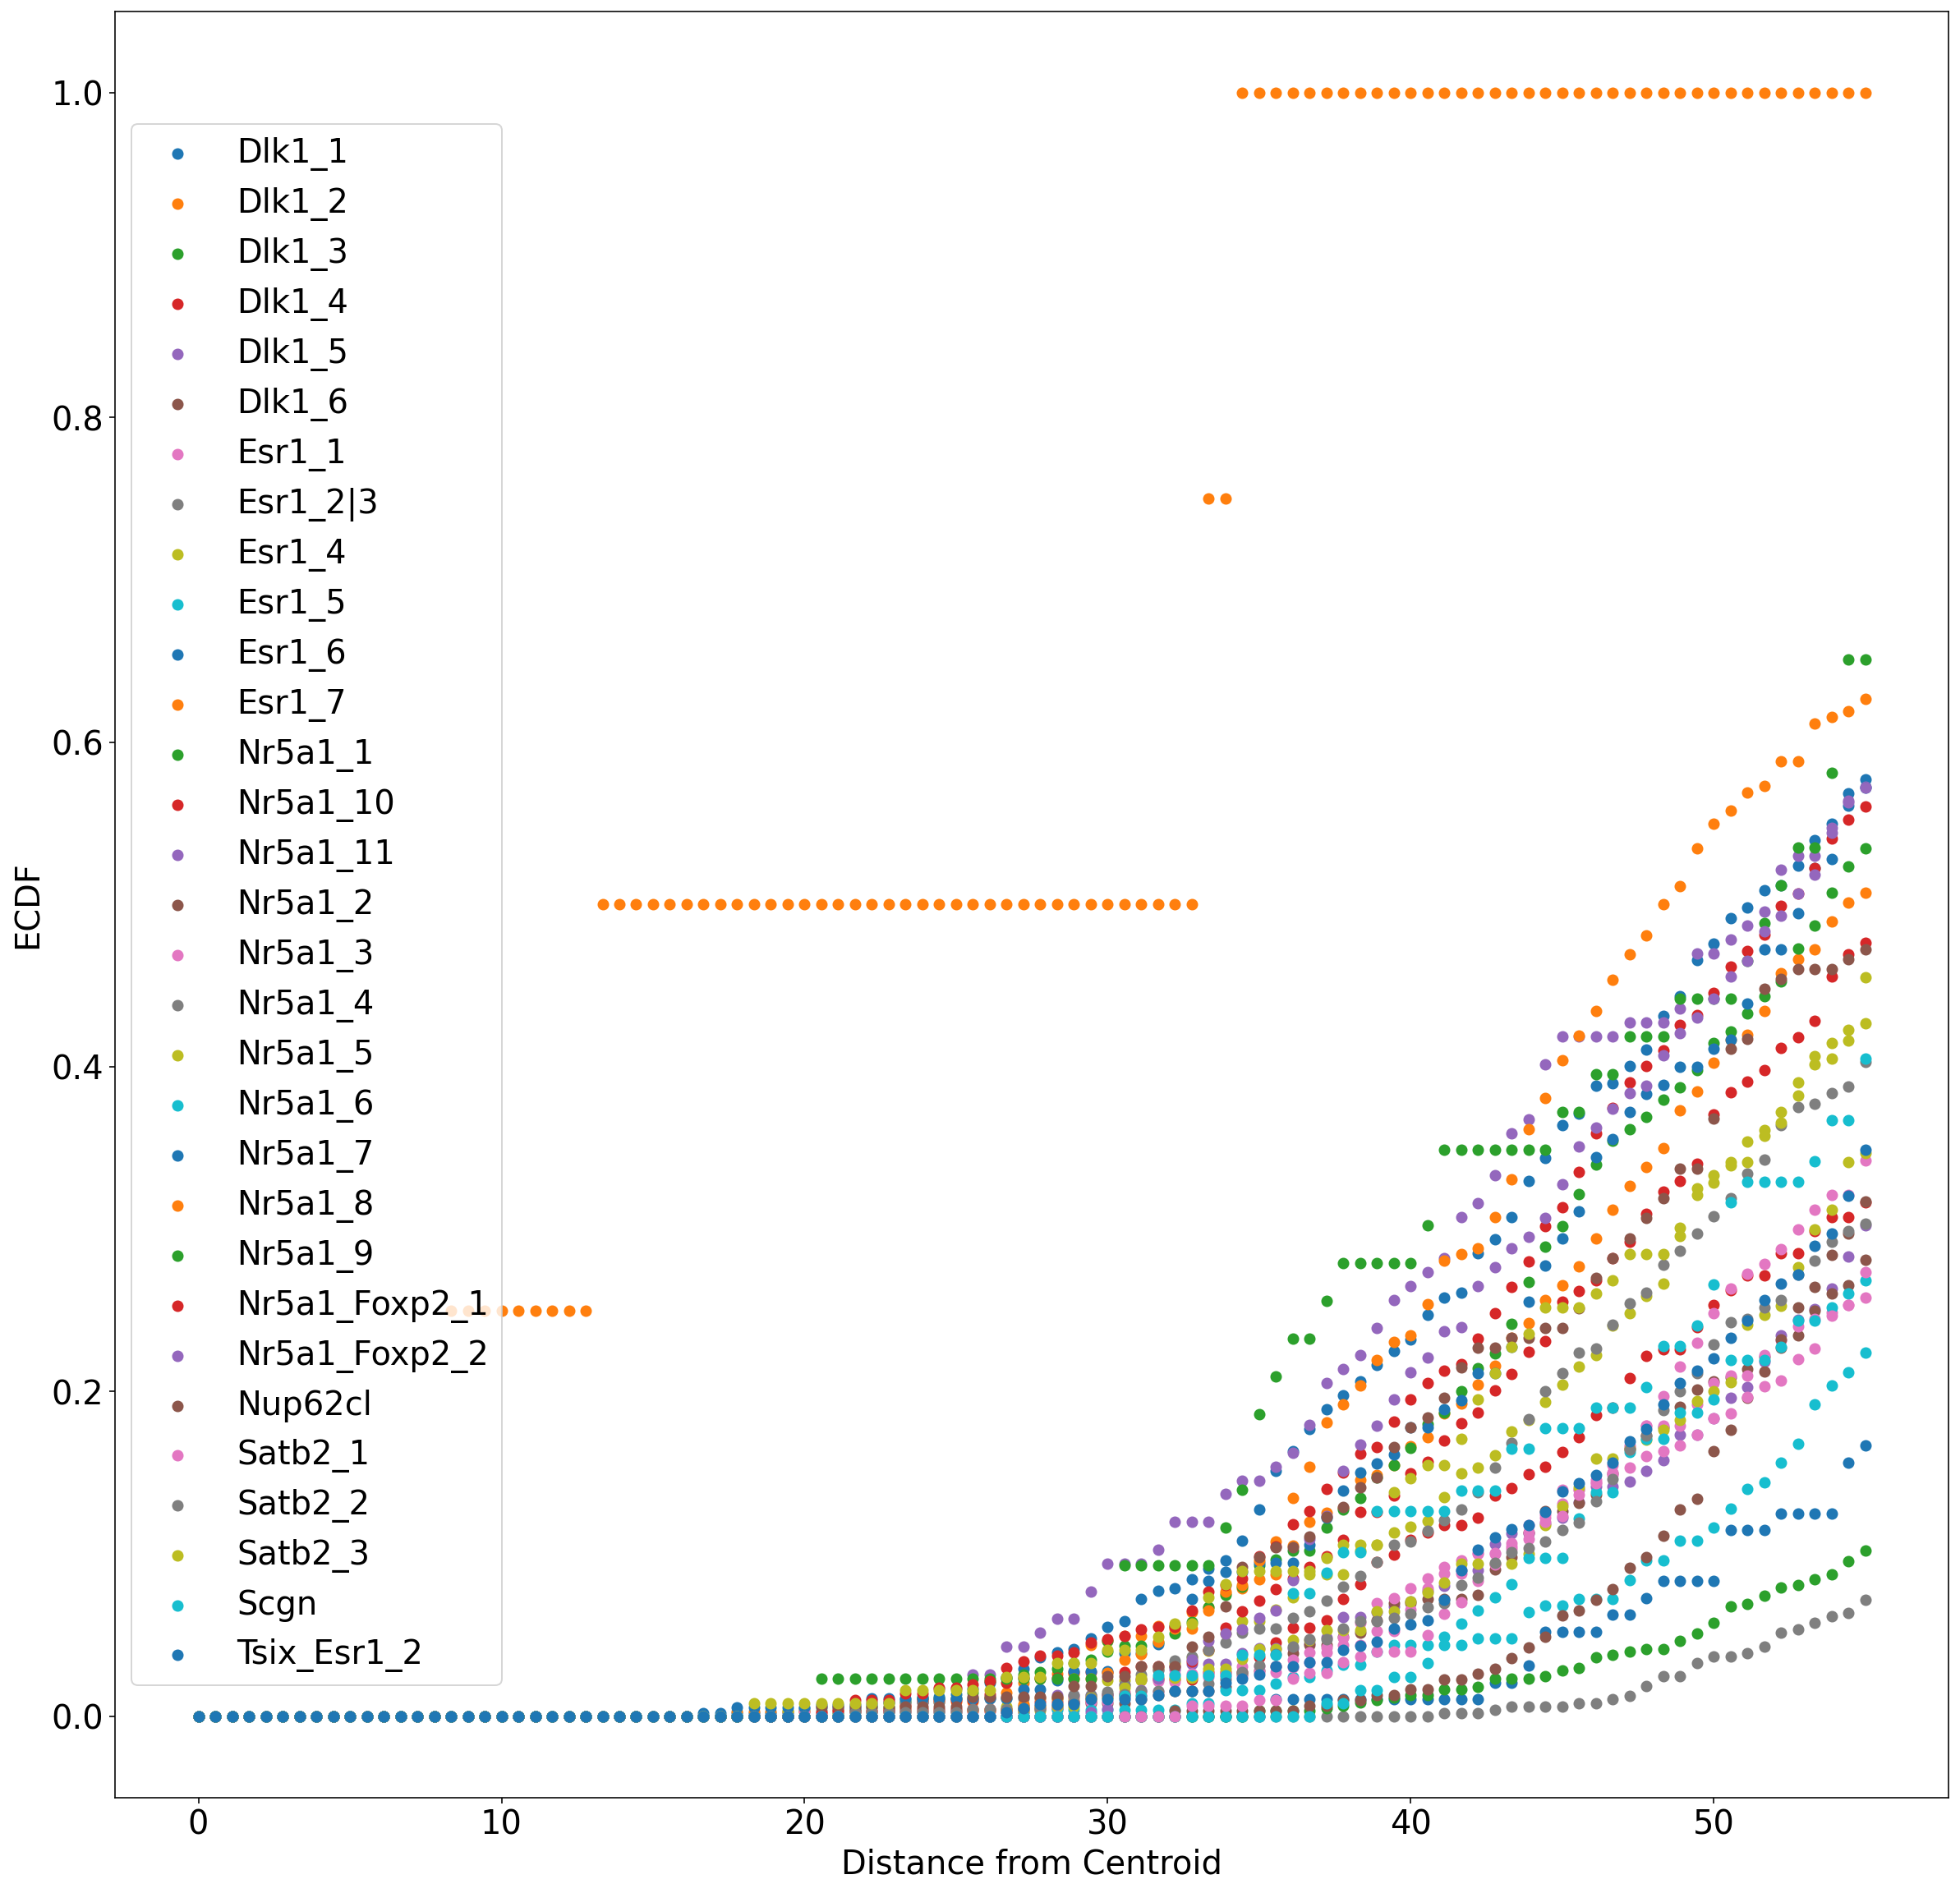

In [58]:
x = np.linspace(0, 55, num=100)
fig, ax = plt.subplots(figsize = (20, 20))
for c in list(NCA_w_sex_label.keys()):
    y = nc.ecdf(x, NCA_w_sex_label[c][0])
    ax.scatter(x, y, label = c)
ax.legend(loc = "center left")
ax.set_xlabel("Distance from Centroid")
ax.set_ylabel("ECDF")
plt.savefig("Centroid Distances by CCA cluster and Sex Label")

In [66]:
nc.tSNE(combined, "X_PCA_10")

In [67]:
combined

AnnData object with n_obs × n_vars = 9065 × 3998
    obs: 'cca_cluster_id', 'cell_types', 'cca_cluster_color', 'sex_label', 'sample_name', 'cca_cluster', 'cell_barcode', 'batch_indices', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'batch'
    var: 'gene_name-0', 'gene_counts-0', 'n_cells-0', 'pass_gene_filter-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_counts-1', 'n_cells-1', 'pass_gene_filter-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_PCA_10', 'X_PCA_20', 'X_PCA_30', 'X_PCA_40', 'X_PCA_50', 'X_PCA_60', 'X_PCA_70', 'X_pca', 'NCA_no_PCA', 'NCA_no_PCA_tsne', 'NCA_10_PCA_10', 'NCA_10_PCA_10_tsne', 'NCA_10_PCA_20', 'NCA_10_PCA_20_tsne', 'NCA_10_PCA_30', 'NCA_10_PCA_30_tsne', 'NCA_10_PCA_40', 'NCA_10_PCA_40_tsne', 'NCA_10_PCA_50', 'NCA_10_PCA_50_tsne', 'NCA_10_PCA_60', 'NCA_10_PCA_60_tsne', 'NCA_10_PCA_70', 'NCA_10_PCA_70_tsne', 'X_pca_tsne', 'X_PCA_10_tsne'
    layers: 'r

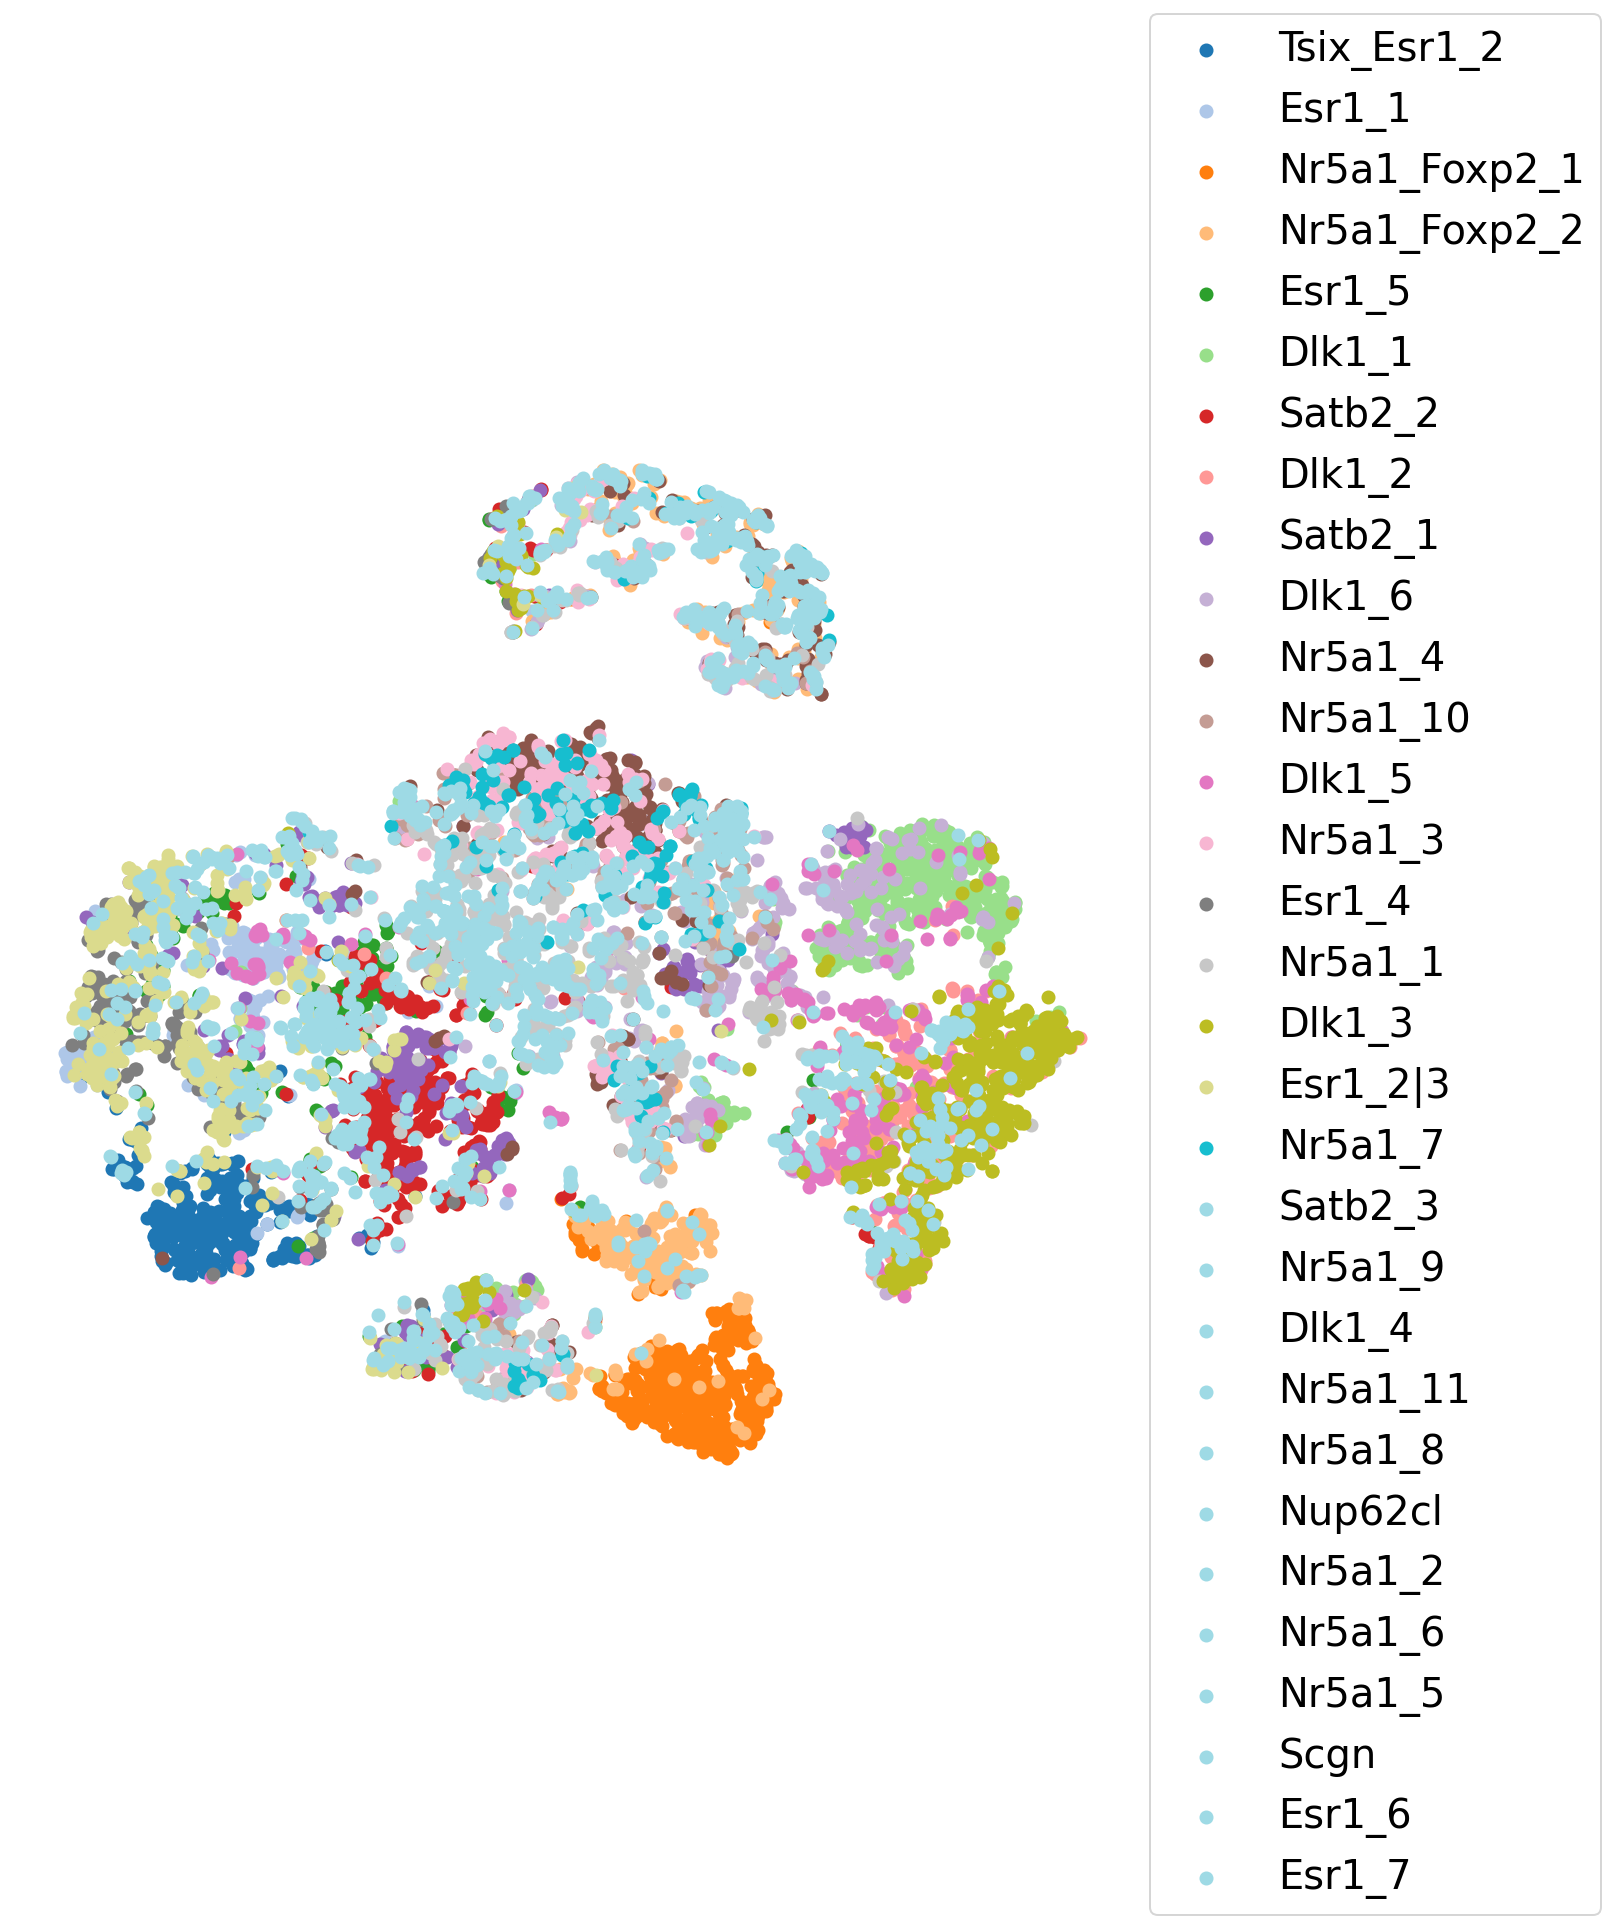

In [70]:
fig, ax = plt.subplots(figsize = (10, 10))
clusters = pd.unique(combined.obs.cca_cluster.values)
cmap = cm.get_cmap("tab20")
for idx, c in (enumerate(clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_PCA_10_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = cmap(idx))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))

In [ ]:
combined.n_obs

In [ ]:
centroids = (NCA.distance_from_centroid(combined, "cca_cluster", nca_label = "X_nca_cca_cluster"))

In [ ]:
all_distances = (list(centroids.values()))

In [ ]:
all_distances = np.array(all_distances[0][0])

In [ ]:
p = iqplot.ecdf(all_distances, q = "Distance from centroid")
p.title.text = "Distances from Centroid with Gender and CCA label"
bokeh.io.show(p)

In [ ]:
NCA.NCA_analysis(combined, "cca_cluster", "cca_cluster", ndims = 10, PCA_dims = 30)

In [ ]:
centroids_CCA_only = NCA.distance_from_centroid(combined, "cca_cluster", nca_label = "X_nca_cca_cluster")

In [ ]:
CCA_distances = np.array(list(centroids_CCA_only.values())[0][0])

In [ ]:
p1 = iqplot.ecdf(CCA_distances, q = "distance from centroid")
p1.title.text = "Distances from Centroid w/ only CCA labels"
bokeh.io.show(p1)

In [ ]:
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

In [ ]:
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

In [ ]:
# PCA
X = SM_data.X[:,SM_hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
SM_data.obsm["X_pca"] = tsvd.fit_transform(X)

In [ ]:
import louvain

In [ ]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
sc.tl.louvain(data)

In [ ]:
sc.pp.neighbors(SM_data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)
sc.tl.louvain(SM_data)
SM_hvg_data = SM_data[:, SM_hvg_mask]

In [ ]:
hvg_data = data[:, hvg_mask]

In [ ]:
copy = hvg_data.copy()
copy.obs["nca_label"] = copy.obs["sample_name"]
hvg_data.obs["nca_label"] = hvg_data.obs["cca_cluster"]
tenx = hvg_data.concatenate(copy, join = "outer")

In [ ]:
X = tenx.X
y = tenx.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state)
tenx.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# t-SNE the NCA projection
X = tenx.obsm["X_nca"]
tenx_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
tenx.obsm["X_nca_tsne"] = tenx_tsne.fit_transform(X)

In [ ]:
# Plot tSNE projection of NCA colored by sample (left) and CCA label (right)
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(30,15))
cmap = cm.get_cmap("tab20")
for i, f in (enumerate(folders)):
    XX = tenx[tenx.obs.sample_name == f,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=f, color = cmap(i))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
clusters = pd.unique(tenx.obs.cca_cluster.values)
colors = pd.unique(tenx.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = tenx[tenx.obs.nca_label == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, label=c, color = idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.tight_layout()

In [ ]:
# NCA
#X = hvg_data.X
#y = hvg_data.obs.louvain.values # you could use louvain here also

#nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
#hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# NCA
#X = hvg_data.X
#y = hvg_data.obs.cca_cluster_id.values # you could use louvain here also

#nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
#hvg_data.obsm["X_paper_nca"] = nca.fit_transform(X, y)

In [ ]:
#Check for overfitting
X = hvg_data.obsm["X_pca"]
y = hvg_data.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# NCA
X = SM_hvg_data.obsm["X_pca"]
y = SM_hvg_data.obs.cca_cluster_id.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state, init="identity")
SM_hvg_data.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

In [ ]:
# t-SNE the NCA projection
X = hvg_data.obsm["X_nca"]
hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
hvg_data.obsm["X_nca_tsne"] = hvg_tsne.fit_transform(X)


In [ ]:
#Check for overfitting
from sklearn.utils import shuffle
cluster_ids = hvg_data.obs.cca_cluster_id.values
cluster_colors = hvg_data.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
hvg_data.obs["random_labels"] = cluster_ids
hvg_data.obs["random_colors"] = cluster_colors
X = hvg_data.obsm["X_pca"]
y = hvg_data.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
hvg_data.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = hvg_data.obsm["X_nca_shuffled"]
hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
hvg_data.obsm["X_nca_tsne_shuffled"] = hvg_tsne.fit_transform(X)

In [ ]:
#Check for overfitting
SM_cluster_ids = SM_hvg_data.obs.cca_cluster_id.values
SM_cluster_colors = SM_hvg_data.obs.cca_cluster_color.values
SM_cluster_ids, SM_cluster_colors = shuffle(SM_cluster_ids, SM_cluster_colors, random_state=0)
SM_hvg_data.obs["random_labels"] = SM_cluster_ids
SM_hvg_data.obs["random_colors"] = SM_cluster_colors
X = SM_hvg_data.obsm["X_pca"]
y = SM_hvg_data.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
SM_hvg_data.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = SM_hvg_data.obsm["X_nca_shuffled"]
SM_hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
SM_hvg_data.obsm["X_nca_tsne_shuffled"] = SM_hvg_tsne.fit_transform(X)

In [ ]:
# t-SNE the NCA projection
X = SM_hvg_data.obsm["X_nca"]
SM_hvg_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
SM_hvg_data.obsm["X_nca_tsne"] = SM_hvg_tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cmap = cm.get_cmap("tab20")
for i, f in (enumerate(folders)):
    XX = hvg_data[hvg_data.obs.batch_indices == i,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=f, alpha = 0.2, color = cmap(i))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(hvg_data.obs.cca_cluster.values)
colors = pd.unique(hvg_data.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = hvg_data[hvg_data.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(hvg_data.obs.cca_cluster_color.values).astype(str)
clusters = pd.unique(hvg_data.obs.random_labels)
for idx, c in (zip(colors, clusters)):
    XX = hvg_data[hvg_data.obs.cca_cluster_id == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color = idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
combined = hvg_data.concatenate(SM_hvg_data, join = "outer")

In [ ]:
combined.X = np.nan_to_num(combined.X)

In [ ]:
combined

In [ ]:
# PCA
X = combined.X

tsvd = TruncatedSVD(n_components=num_PCA)
combined.obsm["X_pca"] = tsvd.fit_transform(X)

In [ ]:
#tsne
X = combined.obsm["X_pca"] 
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.cca_cluster == cluster, :].obsm["X_pca_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
A = combined.obsm["X_pca"]
b = combined.obs.nca_label.values
combined.obsm ["X_nca"] = nca.fit_transform(A, b)

In [ ]:
X =combined.obsm["X_nca"]
tsne = TSNE(n_components = num_TSNE, metric=metric, random_state =state)
combined.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.cca_cluster == cluster, :].obsm["X_pca_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
technology = combined.copy()

In [ ]:
technology.obs["nca_label"] = technology.obs.batch.values
technology.obs["shuffled_label"] = shuffle(technology.obs.batch.values, random_state = state)

In [ ]:
combined.obs["nca_label"] = combined.obs["cca_cluster"].values
combined.obs["shuffled_label"] = shuffle(combined.obs.cca_cluster.values, random_state = state)
duplicate = combined.copy()
duplicate.obs["nca_label"] = duplicate.obs["sex_label"].values
duplicate.obs["shuffled_label"] = shuffle(duplicate.obs.sex_label.values, random_state = state)
double = combined.concatenate(duplicate, join = "outer")

In [ ]:
NCA.NCA_analysis(combined, "shuffled_label", "shuffled_label", fname = "Kim_et_al_shuffled")

In [ ]:
new_dataset = technology.concatenate(combined, join = "outer")

In [ ]:
X = new_dataset.obsm["X_pca"]
y = new_dataset.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
nca.fit(X, y)
A = combined.obsm["X_pca"]
b = combined.obs.nca_label.values
combined.obsm ["X_nca"] = nca.transform(A)
A = combined.obsm["X_pca"]
b = combined.obs.shuffled_label.values
combined.obsm["X_nca_shuffled"] = nca.transform(A)

In [ ]:
X = combined.obsm["X_nca_shuffled"]
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_nca_shuffled_tsne"] = tsne.fit_transform(X)

In [ ]:
X = combined.obsm["X_nca"]
tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
combined.obsm["X_nca_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.shuffled_label == cluster, :].obsm["X_nca_shuffled_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values)
for cluster, color in zip(clusters, colors):
    XX = combined[combined.obs.cca_cluster == cluster, :].obsm["X_nca_tsne"]
    x = XX[:, 0]
    y = XX[:, 1]
    ax.scatter(x, y, label = cluster, color = color)
ax.set_axis_off()
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
X = double.obsm["X_pca"]
y = double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
nca.fit(X, y)
A = combined.obsm["X_pca"]
b = combined.obs.nca_label.values
combined.obsm["X_nca_gender"] = nca.transform(A)
C = combined.obsm["X_pca"]
d = combined.obs.shuffled_label.values
combined.obsm["X_nca_gender_shuffled"] = nca.transform(C)

In [ ]:
X = combined.obsm["X_nca_gender_shuffled"]
tsne = TSNE(n_components = num_TSNE, random_state = state, metric = metric)
combined.obsm["X_gender_shuffled_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.shuffled_label.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.shuffled_label == c,:].obsm["X_gender_shuffled_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (.95, 0.5))
XX = combined[combined.obs.sex_label == 'F',:].obsm["X_gender_shuffled_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r', alpha = 0.7)
XX = combined[combined.obs.sex_label == 'M',:].obsm["X_gender_shuffled_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b', alpha = 0.3)
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
X = combined.obsm["X_nca_gender"]
tsne = TSNE(n_components = num_TSNE, random_state = state, metric = metric)
combined.obsm["X_gender_tsne"] = tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_gender_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (.95, 0.5))
XX = combined[combined.obs.sex_label == 'F',:].obsm["X_gender_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r', alpha = 0.7)
XX = combined[combined.obs.sex_label == 'M',:].obsm["X_gender_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b', alpha = 0.3)
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
shuffled_labels = shuffle(duplicate.obs["nca_label"].values, random_state = 0)
duplicate.obs["nca_label"] = shuffled_labels
shuffled_double = combined.concatenate(duplicate, join = "outer")

In [ ]:
X = shuffled_double.obsm["X_pca"]
y = shuffled_double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init = "identity")
shuffled_double.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
X = shuffled_double.obsm["X_nca"]
double_tsne = TSNE(n_components = num_TSNE, metric = metric, random_state = state)
shuffled_double.obsm["X_nca_tsne"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(shuffled_double.obs.cca_cluster.values)
colors = pd.unique(shuffled_double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = shuffled_double[shuffled_double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
XX = shuffled_double[shuffled_double.obs.nca_label == 'F',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r')
XX = shuffled_double[shuffled_double.obs.nca_label == 'M',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b')
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
X = double.obsm["X_pca"]
y = double.obs.nca_label.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state = state, init="identity")
double.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
# t-SNE the NCA projection
X = double.obsm["X_nca"]
double_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
double.obsm["X_nca_tsne"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(double.obs.cca_cluster.values)
colors = pd.unique(double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = double[double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
XX = double[double.obs.sex_label == 'F',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label='female', c = 'r')
XX = double[double.obs.sex_label == 'M',:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax2.scatter(x, y, label = 'male', c = 'b')
ax2.set_axis_off()
ax2.legend()
plt.show()

In [ ]:
#Check for overfitting
cluster_labels = double.obs.nca_label.values
cluster_colors = double.obs.cca_cluster_color.values
cluster_labels, cluster_colors = shuffle(cluster_labels, cluster_colors, random_state=0)
double.obs["random_labels"] = cluster_labels
double.obs["random_colors"] = cluster_colors
X = double.obsm["X_pca"]
y = double.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init = "identity")
double.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = double.obsm["X_nca_shuffled"]
double_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
double.obsm["X_nca_tsne_shuffled"] = double_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(double.obs.cca_cluster.values)
colors = pd.unique(double.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = double[double.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(double.obs.random_colors.values).astype(str)
clusters = pd.unique(double.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = double[double.obs.random_labels == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    #ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
#Check for overfitting
X = combined.obsm["X_pca"]
y = combined.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
combined.obsm["X_nca"] = nca.fit_transform(X, y)

In [ ]:
#Check for overfitting
X = combined.X
y = combined.obs.cca_cluster_id.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state)
combined.obsm["X_sklearn_nca"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_sklearn_nca"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_sklearn_nca_tsne"] = combined_tsne.fit_transform(X)

In [ ]:
#Check for overfitting
cluster_ids = combined.obs.cca_cluster_id.values
cluster_colors = combined.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
combined.obs["random_labels"] = cluster_ids
combined.obs["random_colors"] = cluster_colors
X = combined.X
y = combined.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state)
combined.obsm["X_sklearn_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_sklearn_nca_shuffled"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_sklearn_nca_tsne_shuffled"] = combined_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_sklearn_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(combined.obs.random_colors.values).astype(str)
clusters = pd.unique(combined.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = combined[combined.obs.random_labels == c,:].obsm["X_sklearn_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
# t-SNE the NCA projection
X = combined.obsm["X_nca"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_nca_tsne"] = combined_tsne.fit_transform(X)

In [ ]:
#Check for overfitting
cluster_ids = combined.obs.cca_cluster_id.values
cluster_colors = combined.obs.cca_cluster_color.values
cluster_ids, cluster_colors = shuffle(cluster_ids, cluster_colors, random_state=0)
combined.obs["random_labels"] = cluster_ids
combined.obs["random_colors"] = cluster_colors
X = combined.obsm["X_pca"]
y = combined.obs.random_labels.values
nca = NeighborhoodComponentsAnalysis(n_components = num_NCA, random_state=state, init="identity")
combined.obsm["X_nca_shuffled"] = nca.fit_transform(X, y)
# t-SNE the NCA projection
X = combined.obsm["X_nca_shuffled"]
combined_tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
combined.obsm["X_nca_tsne_shuffled"] = combined_tsne.fit_transform(X)

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_sklearn_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color = idx)
plt.title("PCA Initialized")
ax2.set_axis_off()
#ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(40,20))
cmap = cm.get_cmap("viridis")
clusters = pd.unique(combined.obs.cca_cluster.values)
colors = pd.unique(combined.obs.cca_cluster_color.values).astype(str)
for idx, c in (zip(colors, clusters)):
    XX = combined[combined.obs.cca_cluster == c,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=c, color = idx)
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("Not shuffled")
#fig, ax = plt.subplots(figsize=(10,10))
colors = pd.unique(combined.obs.random_colors.values).astype(str)
clusters = pd.unique(combined.obs.random_labels)
for idx, c in zip(colors, clusters):
    XX = combined[combined.obs.random_labels == c,:].obsm["X_nca_tsne_shuffled"]
    x = XX[:,0]
    y = XX[:,1]
    ax2.scatter(x, y, color =idx)
ax2.set_axis_off()
ax2.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.title("shuffled")
plt.show()

In [ ]:
combined.obs.sex_label

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
X = SM_hvg_data.X
y = SM_hvg_data.obs.SM_cluster_label
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = hvg_data[hvg_data.obs.batch_indices <= 4,:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = hvg_data[hvg_data.obs.batch_indices > 4,:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = hvg_data[hvg_data.obs.batch_indices <= 4,:].obsm["X_paper_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = hvg_data[hvg_data.obs.batch_indices > 4,:].obsm["X_paper_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = hvg_data.obsm["X_nca_tsne"][:,0]
y = hvg_data.obsm["X_nca_tsne"][:,1]
c = hvg_data.obs["louvain"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

x = SM_hvg_data.obsm["X_nca_tsne"][:,0]
y = SM_hvg_data.obsm["X_nca_tsne"][:,1]
c = SM_hvg_data.obs["SM_cluster_id"].astype(int)
labels = (SM_hvg_data.obs["SM_cluster_label"]).astype(str)
ax.scatter(x, y, c = c, cmap='tab20', label = labels)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
XX = SM_hvg_data[SM_hvg_data.obs.sex_label == "F",:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label='female', c = 'b')
XX = SM_hvg_data[SM_hvg_data.obs.sex_label == "M",:].obsm["X_nca_tsne"]
x = XX[:,0]
y = XX[:,1]
ax.scatter(x, y, label = 'male', c = 'r')
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
sc.tl.rank_genes_groups(SM_hvg_data, "SM_cluster_id", method='wilcoxon', corr_method="bonferroni")

In [ ]:
SM_genes = pd.DataFrame(SM_hvg_data.uns['rank_genes_groups']['names']).to_numpy()
SM_pvals = pd.DataFrame(SM_hvg_data.uns['rank_genes_groups']['pvals']).to_numpy()

In [ ]:
SM_pvals

In [ ]:
unique = np.unique(SM_data.obs.louvain.values).astype(str)
SM_markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])
unique_id = np.unique(SM_data.obs.SM_cluster_id.values).astype(str)
SM_markers = pd.DataFrame(index = unique_id, columns = ["gene_name", "p_value"])

In [ ]:
unique_id

In [ ]:
for un, u in enumerate(unique_id):
    g = SM_genes[:,un]
    p = SM_pvals[:,un]
    SM_markers.loc[u]["gene_name"]  = g.tolist()
    SM_markers.loc[u]["p_value"] = p.tolist()

In [ ]:
SM_markers_gene = SM_markers_gene.apply(pd.Series.explode).reset_index()
SM_markers_gene = SM_markers_gene.rename(columns={"index":'louvain'})
SM_markers = SM_markers.apply(pd.Series.explode).reset_index()
SM_markers = SM_markers.rename(columns={"index": "SM_id"})
SM_cluster = SM_markers.drop_duplicates(["SM_id"])["SM_id"].values
SM_genes = SM_markers.drop_duplicates(["SM_id"])["gene_name"].values

In [ ]:
SM_specific_cluster = SM_markers_gene.drop_duplicates(["louvain"])["louvain"].values
SM_specific_gene = SM_markers_gene.drop_duplicates(["louvain"])["gene_name"].values

In [ ]:
len(c)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(SM_hvg_data.obs["SM_cluster_id"].values.astype(int))
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, SM_genes)):
    XX = SM_hvg_data[SM_hvg_data.obs.SM_cluster_id == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx/10), label= cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [ ]:
unique_neuron_clusters = pd.unique(np.nan_to_num(hvg_data.obs.neuron_cluster_id))

In [ ]:
unique_cca_clusters = pd.unique(np.nan_to_num(hvg_data.obs.cca_cluster_id))

In [ ]:
unique_cca_labels = pd.unique(hvg_data.obs.cca_cluster)

In [ ]:
unique_neuron_clusters[0] = -1.0
unique_neuron_clusters[1] = 0.0

In [ ]:
unique_cca_clusters = unique_cca_clusters.astype(float)

In [ ]:
unique_neuron_labels = pd.unique(hvg_data.obs.neuron_cluster)

In [ ]:
np.sum(unique_cca_clusters)

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_cca_clusters, unique_cca_labels):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label = cluster, color = cmap(idx/100))
ax.set_axis_off()
ax.legend(title = 'VMH_neuron_cca_cluster', loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("VMH_neuron_cca_clusters")

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_cca_clusters, unique_cca_labels):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_paper_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label = cluster, color = cmap(idx/100))
ax.set_axis_off()
ax.legend(title = 'VMH_neuron_cca_cluster', loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.savefig("VMH_neuron_cca_clusters")

In [ ]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(7,7))
for (idx, cluster) in zip(unique_neuron_clusters, unique_neuron_labels):
    XX = hvg_data[hvg_data.obs.neuron_cluster == cluster,:].obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, label=cluster, alpha = 0.5, color = cmap(idx))
ax.set_axis_off()
ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()


In [ ]:
non_null = hvg_data.obs.cca_cluster.values

In [ ]:
hvg_data.obs.cca_cluster_id = hvg_data.obs.cca_cluster_id.astype('category')

In [ ]:
sc.tl.rank_genes_groups(hvg_data, "cca_cluster", method='wilcoxon', corr_method="bonferroni")

In [ ]:
genes = pd.DataFrame(hvg_data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(hvg_data.uns['rank_genes_groups']['pvals']).to_numpy()

In [ ]:
unique = np.unique(data.obs.cca_cluster.values).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [ ]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [ ]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'cca'})

In [ ]:
specific_cluster = markers_gene.drop_duplicates(["cca"])["cca"].values
specific_gene = markers_gene.drop_duplicates(["cca"])["gene_name"].values

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

c = pd.unique(hvg_data.obs["cca_cluster"].values.astype(str))
labels = pd.unique(hvg_data.obs["cca_cluster"].values.astype(str))
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = hvg_data[hvg_data.obs.cca_cluster == cluster,:].obsm["X_paper_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label= cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()